In [2]:
#!pip install wandb -q
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "MultiClassifier.ipynb"
import warnings
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.multiprocessing as mp
import time
from sklearn.model_selection import ParameterGrid
import cv2
import numpy as np
import torchvision
import PIL.Image as Image
import glob
from torchvision.transforms import functional as F
#from torchvision.transforms.v2 import functional as F
from IPython.display import display
#import wandb
from datetime import datetime
import gc
test_id = "1024_13_no_preprocessing_channel_check"
print(test_id)

import seaborn as sns 
import torch
import torch.nn as nn
import torch.nn.functional as Fu
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset, random_split
from torchvision import datasets, transforms, models

import numpy as np
import os
import shutil 
import matplotlib.pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchvision.models import resnet50, ViT_H_14_Weights, ResNet50_Weights, EfficientNet_B5_Weights, EfficientNet_V2_S_Weights, AlexNet_Weights, Wide_ResNet101_2_Weights
import itertools
from torch.utils.data import Subset

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torch import manual_seed
from PIL import ImageEnhance
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

torch.backends.cudnn.benchmark = True
import gc
#!del variable_name
gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
def cleanup():
    dist.destroy_process_group()


In [3]:
import numpy as np
import torch
from torch.utils.data import Subset

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt',check_point=True, trace_func=print, mode='min'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement. 
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
            trace_func (function): trace print function.
            mode (str): One of {'min', 'max'}. In 'min' mode, training will stop when the quantity 
                        monitored has stopped decreasing; in 'max' mode it will stop when the 
                        quantity monitored has stopped increasing.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_min = np.Inf
        self.val_max = np.NINF
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.img_size = None
        self.mode = mode
        self.check_point = check_point

    def __call__(self, val_metric, model, optimizer):
        if self.mode == 'min':
            score = -1. * val_metric
        else:
            score = np.copy(val_metric)
        
        if self.best_score is None:
            self.best_score = score
            if self.check_point == True:
                self.save_checkpoint(val_metric, model, optimizer)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.check_point == True:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            if self.check_point == True:
                self.save_checkpoint(val_metric, model, optimizer)
            self.counter = 0

    def save_checkpoint(self, val_metric, model, optimizer):
        '''Saves model when metric improves.'''
        if self.verbose:
            if self.mode == 'min':
                self.trace_func(f'Validation metric decreased ({self.val_min:.6f} --> {val_metric:.6f}).  Saving model ...')
            else:
                self.trace_func(f'Validation metric increased ({self.val_max:.6f} --> {val_metric:.6f}).  Saving model ...')
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, self.path)
        if self.mode == 'min':
            self.val_min = val_metric
        else:
            self.val_max = val_metric


class TransformedSubset(Subset):
    def __init__(self, subset, transform=None):
        super(TransformedSubset, self).__init__(subset.dataset, subset.indices)
        self.transform = transform

    def __getitem__(self, index):
        x, y = super(TransformedSubset, self).__getitem__(index)
        if self.transform:
            x = self.transform(x)
        return x, y


In [4]:
class CenterCropPercentage:
    def __init__(self, percentage):
        assert 0 < percentage <= 1, "Percentage should be between 0 and 1"
        self.percentage = percentage

    def __call__(self, img):
     #   print("CenterCropPercentage is called!")
        width, height = img.size
        new_width, new_height = width * self.percentage, height * self.percentage
        left = (width - new_width) / 2
        top = (height - new_height) / 2
        right = (width + new_width) / 2
        bottom = (height + new_height) / 2
        cropped_img = img.crop((left, top, right, bottom))
       # print("Cropped Image Size:", cropped_img.size)
        return cropped_img

    def __repr__(self):
        return self.__class__.__name__ + '(percentage={0})'.format(self.percentage)



In [5]:
from enum import Enum

class ColorType(Enum):
    GRAY = 0
    COLOR = 1

class DataSet(Enum):
    ALL   = 0
    TRAIN = 1
    VAL   = 2
    TEST  = 3
    TRAIN_LOADER = 4
    VALID_LOADER = 5
    TEST_LOADER = 6
 

import os
import shutil
from sklearn.model_selection import train_test_split

def split_and_copy_files(dataset_path, train_portion, val_portion):
    # 모든 이미지 경로 가져오기
    all_images = []
    all_labels = []
    for class_folder in ['cancer', 'not_cancer']:
        class_folder_path = os.path.join(dataset_path, class_folder)
        for img_file in os.listdir(class_folder_path):
            all_images.append(os.path.join(class_folder_path, img_file))
            all_labels.append(class_folder)

    # 이미지 경로를 훈련/검증/테스트로 분할
    train_images, temp_images, train_labels, temp_labels = train_test_split(
        all_images, all_labels, train_size=train_portion, stratify=all_labels, random_state=42)
    
    val_size = val_portion / (1 - train_portion)
    val_images, test_images, val_labels, test_labels = train_test_split(
        temp_images, temp_labels, train_size=val_size, stratify=temp_labels, random_state=42)

    base_path = os.path.dirname(dataset_path)
    # 각 분할된 이미지 경로를 해당 폴더로 복사
    for split, images, labels in zip(["train", "val", "test"], [train_images, val_images, test_images], [train_labels, val_labels, test_labels]):
        split_dir = os.path.join(base_path, split)
        os.makedirs(split_dir, exist_ok=True)
        for img_path, label in zip(images, labels):
            dst_dir = os.path.join(split_dir, label)
            os.makedirs(dst_dir, exist_ok=True)
            shutil.copy(img_path, os.path.join(dst_dir, os.path.basename(img_path)))

    print("Files copied successfully!")

dataset_path = 'datasets/CBIS-DDSM/train_256/'
#split_and_copy_files(dataset_path, train_portion=0.7, val_portion=0.2)


In [6]:
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


In [7]:
# from PIL import Image, ImageEnhance
# import numpy as np
# import matplotlib.pyplot as plt

 
# # Load a sample image
# image_path = '11.png'  # Update with your image path
# sample_image = Image.open(image_path)

# # Adjust its brightness
# adjusted_image = adjust_image_transform(sample_image, brightness_factor=1.2, color_factor=1.0, contrast_factor=0.9)
# # Convert images to numpy arrays for plotting
# original_np = np.array(sample_image)
# adjusted_np = np.array(adjusted_image)

# # Plot original and adjusted images side by side for comparison
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.imshow(original_np, cmap='gray')
# plt.title('Original')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(adjusted_np, cmap='gray')
# plt.title('Adjusted Brightness')
# plt.axis('off')

# plt.tight_layout()
# plt.show()


In [8]:
# from torchvision import transforms 
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import cv2
import numpy as np
 

def np_array_to_image(np_img):
    # Squeeze unnecessary singleton dimensions
    np_img = np.squeeze(np_img)

    # Ensure the NumPy array is 3D: (H, W, C)
    if len(np_img.shape) != 3:
        raise ValueError("Array needs to be 3D, got shape {}".format(np_img.shape))

    # Ensure channel order is correct
    if np_img.shape[2] != 3:
        raise ValueError("Last dimension should be 3 (for R, G, B), got {}".format(np_img.shape[2]))
 
    # Convert float images
    if np_img.dtype == np.float32 or np_img.dtype == np.float64:
        # Ensure the values are between 0 and 1
        if np_img.max() > 1.0 or np_img.min() < 0:
            raise ValueError("Float images should have pixel values between 0 and 1.")
        # Convert to uint8 [0, 255]
        np_img = (np_img * 255).astype(np.uint8)

    # Convert to PIL Image
    img = Image.fromarray(np_img)

    return img
#adjust_image_transform(sample_image, brightness_factor=1.2, color_factor=1.0, contrast_factor=0.9)
def adjust_image_transform(img, brightness_factor=1.2, color_factor=1.0, contrast_factor=0.9):
    """Adjust brightness, color (saturation), and contrast of an image using torchvision transform.
    
    Args:
        img (PIL.Image): Input image.
        brightness_factor (float): Factor to adjust brightness. Default is 1.4.
        color_factor (float): Factor to adjust color (saturation). Default is 1.1.
        contrast_factor (float): Factor to adjust contrast. Default is 1.5.

    Returns:
        PIL.Image: Adjusted image.
    """
    img = ImageEnhance.Brightness(img).enhance(brightness_factor)
    img = ImageEnhance.Color(img).enhance(color_factor)
    img = ImageEnhance.Contrast(img).enhance(contrast_factor)
    return img

def apply_effect(img, ksize=10, threshold_values=(155, 255), area_limit=100):
    """
    Applies a custom image effect to the input image.

    Parameters:
        img (PIL.Image or np.array): Input image.
        ksize (int): Size of the kernel. Default is 10.
        threshold_values (tuple of int): Tuple containing two intensity values for thresholding. Default is (155, 255).
        area_limit (int): The area limit for contour selection. Default is 100.
    
    Returns:
        PIL.Image or np.array: Processed image.
    """
    # Convert PIL Image to NumPy array if it is not
    if not isinstance(img, np.ndarray):
        img_np = np.array(img)
    else:
        img_np = img
    
    # Convert the image to grayscale if it is not
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        gray = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
    else:
        gray = img_np

    # Apply a binary threshold to the image
    _, thresh = cv2.threshold(gray, *threshold_values, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    output = np.zeros_like(thresh)
    for cnt in contours:
        if cv2.contourArea(cnt) < area_limit:
            cv2.drawContours(output, [cnt], -1, (255, 255, 255), -1)

    # Region to keep original values
    start = int(ksize*.3)
    end = int(ksize*.7)

    # Create a kernel filled with zeros
    kernel = np.zeros((ksize, ksize), np.float32)

    # Set the inner region of the kernel to the average value
    kernel[start:end, start:end] = 1 / ((end - start) ** 2)

    # Apply the custom kernel to the image using 2D filtering
    smoothed_output = cv2.filter2D(output, -1, kernel)

    # Convert NumPy array back to PIL Image if the original input was a PIL Image
    if isinstance(img, Image.Image):
        return Image.fromarray(smoothed_output.astype('uint8'))
    else:
        return smoothed_output
    
def gaussian_blur(img):
    np_img = np.array(img)
    blurred = cv2.GaussianBlur(np_img, (5, 5), 0)
    return Image.fromarray(blurred)

def grayscale_to_rgb_16bit(img):
    np_img = np.array(img)
 #   print("grayscale_to_rgb")
    # Check if the image is grayscale
    if len(np_img.shape) == 2 or np_img.shape[0] == 1:  
        np_img = np.stack([np_img] * 3, axis=-1)
    elif np_img.shape[0] == 3:  # Move the channel dimension to the end
        np_img = np.transpose(np_img, (1, 2, 0))

 #   print("gray 22222")
    # Normalize here, if not done in __getitem__
    np_img = np_img / 65535.0  # assuming the original dtype was uint16
   # print("gray 3333")
    return np_array_to_image(np_img)

def grayscale_to_rgb(img):
    np_img = np.array(img)
    if len(np_img.shape) == 2:  # Check if the image is grayscale
        np_img = np.stack([np_img]*3, axis=-1)
    return Image.fromarray(np_img)


# def enhance_contrast_using_clahe(img):
#     np_img = np.array(img)
#     gray_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2GRAY)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     enhanced_img = clahe.apply(gray_img)
#     enhanced_img_rgb = cv2.cvtColor(enhanced_img, cv2.COLOR_GRAY2RGB)
#     return Image.fromarray(enhanced_img_rgb)
 
 

def enhance_contrast_using_clahe_16bit(img):
    np_img = np.array(img)
    
    # Check if the image is already grayscale
    if len(np_img.shape) == 2 or np_img.shape[2] == 1:
        gray_img = np_img
    else:
        gray_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2GRAY)
    
    # Ensure the image is either 8-bit or 16-bit
    if gray_img.dtype != np.uint8 :
        # You may need to adjust the scaling depending on your use case
        # Here we scale to 0-65535 and convert to uint16
        gray_img = (gray_img - np.min(gray_img)) / (np.max(gray_img) - np.min(gray_img)) * 65535
        gray_img = gray_img.astype(np.uint16)
        
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    enhanced_img = clahe.apply(gray_img)
    
    return enhanced_img

def channel_check(img):
    np_img = np.array(img)
   # print("np_img.shape", np_img.shape)
    # Check if the image is already grayscale
    if len(np_img.shape) == 2 or np_img.shape[2] == 1:
        gray_img = np_img
    else:
        gray_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2GRAY)
        
     
   # print("np_img.shape", gray_img.shape)
    # If you want to return a 3-channel image instead of 1-channel
    # return cv2.cvtColor(enhanced_img, cv2.COLOR_GRAY2RGB)
    
    return gray_img
    
def enhance_contrast_using_clahe(img):
    np_img = np.array(img)
    
    # Check if the image is already grayscale
    if len(np_img.shape) == 2 or np_img.shape[2] == 1:
        gray_img = np_img
    else:
        gray_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2GRAY)
        
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(gray_img)
    
    # If you want to return a 3-channel image instead of 1-channel
    # return cv2.cvtColor(enhanced_img, cv2.COLOR_GRAY2RGB)
    
    return enhanced_img


def adjust_brightness(img, factor=0.02):
    """Adjust brightness of an image.
    
    Args:
        img (PIL.Image or np.ndarray): Input image.
        factor (float): A value between 0 and 1 that determines the brightness. 
                        1 means no change, less than 1 dims the image.

    Returns:
        PIL.Image: Image with adjusted brightness.
    """
    # Check if img is a numpy array and convert it to PIL.Image if it is
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor)

def hist_equalize(img):
    np_img = np.array(img)
    img_yuv = cv2.cvtColor(np_img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return Image.fromarray(img_output)
   
def apply_threshold_effect(img):
   
    ksize = 5

    

    # Define the region to keep original values
    start = int(ksize * 0.3)
    end = int(ksize * 0.7)

    # Create a kernel filled with zeros
    kernel = np.zeros((ksize, ksize), np.float32)

    # Set the inner region of the kernel to keep original values
   # kernel[start:end, start:end] = 1  # setting to 1 will keep the original values during convolution

    
     # Set the inner region of the kernel to the average value
    kernel[ksize-1, ksize-1] = 1 / (ksize ** 2)

    
    # Apply the custom kernel to the image using 2D filtering
    smoothed_output = cv2.filter2D(img, -1, kernel)

    return smoothed_output
    
   

def apply_threshold_effect_good_result(img):
   
    ksize = 5

    # Region to keep original values

    start = int(ksize*.3)
    end = int(ksize*.7)
    # Create a kernel filled with zeros
    kernel = np.zeros((ksize, ksize), np.float32)

    # Set the inner region of the kernel to the average value
    kernel[start:end, start:end] = 1 / ((end - start) ** 2)

    # Apply the custom kernel to the image using 2D filtering
    smoothed_output = cv2.filter2D(img, -1, kernel)

    return smoothed_output
    """
    Apply a binary threshold effect to the image.

    Parameters:
        img (PIL.Image or np.array): The input image.

    Returns:
        PIL.Image or np.array: The thresholded image.
    """
    
    # Convert PIL Image to NumPy array if it is not
    if isinstance(img, Image.Image):
        img_np = np.array(img)
    else:
        img_np = img
    
    # Ensure the image is grayscale
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        gray = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
    else:
        gray = img_np
    
    # Calculate the mean of the non-zero values
    non_zero_mean = np.mean(gray[gray > 0])
    
    # Set the threshold value to 70% of the non-zero mean
    threshold_value = int(0.95 * non_zero_mean)
    
    # Apply a binary threshold to the image using the calculated threshold value
    _, thresh = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
    
    # Convert NumPy array back to PIL Image if the original input was a PIL Image
    if isinstance(img, Image.Image):
        return Image.fromarray(thresh.astype('uint8'))
    else:
        return thresh



def segment_and_visualize(img_np):
    # Convert to grayscale if it's a color image
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(img_np, 0, 255, cv2.THRESH_BINARY )
    kernel = np.ones((2,2), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Check if any contours were found
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(img_np)
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)
        result = cv2.bitwise_and(img_np, img_np, mask=mask)
        return Image.fromarray(result)
    else:
        print("Warning: No contours found in image")
        # Handle the case appropriately: you might return the original image,
        # or you might return a black image of the same shape, etc.
        return Image.fromarray(img_np)  # or whatever is appropriate in context

def sharpen_image(img, alpha=1.5, beta=-100):
    """
    Increase the contrast of the image. 
    
    Args:
        img: np.array, source image
        alpha: float, contrast control. 1.0: same contrast. > 1.0: increase contrast
        beta: float, brightness control. 0: same brightness. > 0: increase brightness
        
    Returns:
        np.array: contrast and brightness adjusted image
    """
    adjusted = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return adjusted

def enhance_edges(img, low_threshold=50, high_threshold=150):
    """
    Apply Canny edge detection to emphasize edges in the image.
    
    Args:
        img: np.array, source image
        low_threshold: int, lower bound for edge detection
        high_threshold: int, upper bound for edge detection
        
    Returns:
        np.array: image with emphasized edges
    """
   # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert the image to grayscale
    edges = cv2.Canny(img, low_threshold, high_threshold)  # Apply Canny edge detection
    return edges

def apply_binary_mask(img, threshold=127):
    """
    Convert image to binary based on a threshold.
    
    Args:
        img: np.array, source image
        threshold: int, pixel intensity threshold
        
    Returns:
        np.array: binary image
    """
    _, binary_mask = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    return binary_mask


def ensure_3_channel_uint8(image):
    """
    Ensure the image is 3-channel and uint8 type.
    
    Args:
        image: np.array, input image
        
    Returns:
        np.array: processed image
    """
    # Ensure the image has 3 channels
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    
    # Ensure the image is uint8 type
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    return image

def denoise_image(image):
    # Ensure the image is in the correct format
    image = ensure_3_channel_uint8(image)
    
    # Apply denoising
    denoised = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    
    return denoised
 
def denoise_grayscale_image(image):
    """
    Apply denoising to a grayscale image.

    Args:
        image: np.array, input image

    Returns:
        np.array: denoised image
    """
    # Ensure image is 2D (H, W) or (H, W, 1)
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif len(image.shape) == 3 and image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2GRAY)
    
    # Ensure the image is uint8 type
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Apply denoising
    denoised = cv2.fastNlMeansDenoising(image, None, 30, 7, 21)
    
    return denoised


def segment_and_visualize_transform(img):
    return segment_and_visualize(np.array(img))

def grayscale_to_rgb_transform(img):
    return grayscale_to_rgb(img)
   
def adjust_pixel_intensity(img):
    """
    Adjust pixel intensities based on the average of non-zero values.
    
    Args:
        img: np.array, source image
        
    Returns:
        np.array: adjusted image
    """
    # Compute the mean of non-zero values
    non_zero_mean = img[img > 0].mean()
    non_zero_mean = non_zero_mean* 1.7
   # print("non_zero_mean",non_zero_mean)
    # Create a mask for values lower than the mean and greater than 0
    mask = (img < non_zero_mean) & (img > 0)
    
    # Update the pixel values: Halve the values lower than the mean and greater than 0
    img[mask] = 0#img[mask] / 10
    
    return img

def bilateralFilter(img):
    smoothed = cv2.bilateralFilter(img, d=15, sigmaColor=75, sigmaSpace=75)
    return smoothed
def fastNlMeansDenoisingColored(img):
    denoised = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    return smoothed
def medianBlur(img):
    blurred = cv2.medianBlur(img, 5)
    return smoothed
 

def cropped_transforms(grayscale=True):
    print("cropped_transforms called")
    transforms_list = [ 
        transforms.Resize((224,224)), 
         
       # transforms.Lambda(gaussian_blur),
    #    transforms.Lambda(segment_and_visualize_transform),
       # transforms.Lambda(enhance_contrast_using_clahe),
        transforms.Lambda(grayscale_to_rgb_transform),  
        transforms.ToTensor()
    ]
    # if grayscale:
    #     mean = [0.456]
    #     std = [0.224]
    # else:
    #     mean = [0.485, 0.456, 0.406]
    #     std = [0.229, 0.224, 0.225]
    # transforms_list.append(transforms.Normalize(mean, std))
    return transforms.Compose(transforms_list)

# def bilateralFilter(img):
#     smoothed = cv2.bilateralFilter(img, d=15, sigmaColor=75, sigmaSpace=75)
#     return smoothed
# def fastNlMeansDenoisingColored(img):
#     denoised = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
#     return smoothed
# def medianBlur(img):
#     blurred = cv2.medianBlur(img, 5)
#     return smoothed
 

    
def valid_transforms(resize=None, img_crop_size = 240, grayscale=True):
    transforms_list = [
    #    transforms.CenterCrop((img_crop_size, img_crop_size))
    ]
    if resize is not None:
        transforms_list.append(transforms.Resize((resize, resize)))
    transforms_list.extend([
     #   transforms.Lambda(adjust_image_transform),  # Move adjust image transform to the beginning
    #    transforms.Lambda(hist_equalize),
        transforms.Lambda(channel_check),
       # transforms.Lambda(gaussian_blur),
        transforms.Lambda(segment_and_visualize_transform),
        transforms.Lambda(enhance_contrast_using_clahe),
     #   transforms.Lambda(lambda x: adjust_brightness(x, 0.9)),
      #  transforms.Lambda(adjust_pixel_intensity),   
     #   transforms.Lambda(gaussian_blur),
     #   transforms.Lambda(denoise_grayscale_image),   
        
      #  transforms.Lambda(grayscale_to_rgb_transform),  
        transforms.ToTensor()
    ])
    
    
    if grayscale:
        mean = [0.456]
        std = [0.224]
    else:
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    transforms_list.append(transforms.Normalize(mean, std))
    return transforms.Compose(transforms_list)

def mammo_transforms(resize=None, img_crop_size=240, grayscale=True):
    print("img_crop_size",img_crop_size)
    transforms_list = [
    #    transforms.CenterCrop((img_crop_size, img_crop_size)),
    ]
    
    if resize is not None:
        transforms_list.append(transforms.Resize((resize, resize)))

    transforms_list.extend([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
         
        transforms.Lambda(channel_check),
    #    transforms.Lambda(adjust_image_transform),  # Move adjust image transform to the beginning
        transforms.Lambda(segment_and_visualize_transform),
        transforms.Lambda(enhance_contrast_using_clahe),
     #   transforms.Lambda(lambda x: adjust_brightness(x, 0.9)),
    #    transforms.Lambda(grayscale_to_rgb_transform),   
    # transforms.Lambda(adjust_pixel_intensity),   
       # transforms.Lambda(gaussian_blur),
      #  transforms.Lambda(denoise_grayscale_image),   
        transforms.ToTensor()
    ])
    
    
    
    if grayscale:
        mean = [0.456]
        std = [0.224]
    else:
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    
    transforms_list.append(transforms.Normalize(mean, std))
    return transforms.Compose(transforms_list)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.6, gamma=0.4, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = Fu.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
 

        

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.6, beta=0.4):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, y_pred, y_true):
        smooth = 1e-5
        y_pred = torch.sigmoid(y_pred)
        
        # Ensure y_true is one-hot encoded
        if len(y_true.shape) == 1 or (len(y_true.shape) == 2 and y_true.shape[1] == 1):
            y_true = F.one_hot(y_true.squeeze().long(), num_classes=y_pred.shape[1]).float()
        elif len(y_true.shape) == 4:  # Handling potential 4D tensor
            y_true = y_true.permute(0, 3, 1, 2).float()

        tp = (y_true * y_pred).sum()
        fn = (y_true * (1-y_pred)).sum()
        fp = ((1-y_true) * y_pred).sum()
        tversky_index = tp / (tp + self.alpha*fn + self.beta*fp + smooth)
        return 1 - tversky_index
    
class DiceLoss(nn.Module):
    def forward(self, y_pred, y_true):
        smooth = 1e-5
        #smooth = 1e-4
         
            

        # If y_true is not already one-hot, make it one-hot
        if len(y_true.shape) == 1 or y_true.shape[1] == 1:  # If it’s not one-hot
            y_true_ohe = F.one_hot(y_true.to(torch.int64), num_classes=y_pred.size(1))
        else:  # If it’s already one-hot
            y_true_ohe = y_true
        
        y_true_ohe = y_true_ohe.float()
        y_pred = torch.sigmoid(y_pred)

        
       
        # Calculating the loss
        intersection = (y_pred * y_true_ohe).sum()
        dice_coef = (2. * intersection + smooth) / (y_pred.sum() + y_true_ohe.sum() + smooth)
        return 1 - dice_coef
    
class DiceTverskyLoss(nn.Module):
    def __init__(self, alpha=0.4, beta=0.6):
        super(DiceTverskyLoss, self).__init__()
        self.alpha = alpha  # Weight for the Tversky loss
        self.beta = beta    # Weight for the Dice loss
        self.tversky_loss = TverskyLoss()
        self.dice_loss = DiceLoss()
    
    def forward(self, y_pred, y_true):
        loss = self.alpha * self.tversky_loss(y_pred, y_true) + self.beta * self.dice_loss(y_pred, y_true)
        return loss
        
class CostSensitiveLoss(nn.Module):
    def __init__(self, fn_cost=2.0, fp_cost=1.0):
        super(CostSensitiveLoss, self).__init__()
        self.fn_cost = fn_cost
        self.fp_cost = fp_cost

    def forward(self, outputs, targets):
        # 확률을 구하기 위한 softmax
        probs = nn.Softmax(dim=1)(outputs)
        positive_probs = probs[:, 1]

        # False Negative 비용
        fn_loss = -torch.mean(targets * torch.log(positive_probs + 1e-10) * self.fn_cost)
        
        # False Positive 비용
        fp_loss = -torch.mean((1 - targets) * torch.log(1 - positive_probs + 1e-10) * self.fp_cost)

        return fn_loss + fp_loss

class CombinedLoss(nn.Module):
    def __init__(self, alpha, gamma, fn_cost, fp_cost, lambda_factor):
        super(CombinedLoss, self).__init__()
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma)
        self.cost_sensitive_loss = CostSensitiveLoss(fn_cost=fn_cost, fp_cost=fp_cost)
        self.lambda_factor = lambda_factor

    def forward(self, inputs, targets):
        return self.lambda_factor * self.focal_loss(inputs, targets) + \
               (1 - self.lambda_factor) * self.cost_sensitive_loss(inputs, targets)

def adjust_threshold(output, threshold=0.5):
    """
    Adjust the threshold for classification.

    Parameters:
        output (torch.Tensor): The raw output from the model.
        threshold (float): The threshold for classification.

    Returns:
        torch.Tensor: The adjusted output.
    """
    probas = Fu.softmax(output, dim=1)  # Compute probabilities using softmax
    predictions = (probas[:, 1] > threshold).float()  # Binary classification based on adjusted threshold
    return predictions

In [9]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming ModelA, ModelB, ModelC, ModelD are your defined model classes
# and they are compatible with the weights in the provided .pt files

class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)
        
#     def forward(self, x):
#         # You may want to modify how you combine the models
#         # Below is a simple average ensemble
#         return torch.mean(torch.stack([model(x) for model in self.models]), dim=0)
    def forward(self, x):
        outputs = [model(x) for model in self.models]
        
        # Convert logits to class probabilities and get the predicted class (argmax over the class dimension)
        predictions = [F.softmax(output, dim=1).argmax(dim=1) for output in outputs]

        # Stack predictions to get a [num_models, batch_size] tensor
        stacked_predictions = torch.stack(predictions)

        # Use mode to find the most common prediction among models for each sample
        mode_values, _ = torch.mode(stacked_predictions, dim=0)

        # If you want to return class probabilities you should average the softmax outputs
        # Otherwise, you should convert the mode values to one-hot encoding and return it
        # if the downstream task/process uses class probabilities.

        return F.one_hot(mode_values, num_classes=stacked_predictions.shape[-1])



In [10]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import numpy as np

def train_meta_model(X_meta, y, test_size=0.2):
    """
    Train a logistic regression model using the meta-features.
    
    Parameters:
        X_meta (np.array): Meta-features used for training the meta-model.
        y (np.array): True labels.
        test_size (float): Proportion of the dataset to include in the test split.
        
    Returns:
        meta_model: Trained meta model.
    """
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_meta, y, test_size=test_size, random_state=42)
    
    # Initialize and train meta model
    meta_model = LogisticRegression(max_iter=1000)
    meta_model.fit(X_train, y_train)
    
    # Evaluate meta model
    predictions = meta_model.predict(X_test)
    print("Meta-model performance:")
    print(classification_report(y_test, predictions))
    
    return meta_model

def evaluate_ensemble(meta_model, new_meta_features, true_labels):
    """
    Use the trained meta model to make predictions on new data and evaluate performance.
    
    Parameters:
        meta_model: Trained meta model.
        new_meta_features (np.array): New meta-features for prediction.
        true_labels (np.array): True labels of the new data.
        
    Returns:
        None
    """
    # Use meta-model to make final predictions on new data
    final_predictions = meta_model.predict(new_meta_features)
    
    # Evaluate the performance of the ensemble
    # You might compare final_predictions to the true labels
    # e.g., using accuracy, precision, recall, etc.
    acc = accuracy_score(true_labels, final_predictions)
    prec = precision_score(true_labels, final_predictions, average='weighted')
    rec = recall_score(true_labels, final_predictions, average='weighted')
    f1 = f1_score(true_labels, final_predictions, average='weighted')
    
    print("Ensemble Model Performance:")
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {rec:.2f}")
    print(f"F1 Score: {f1:.2f}")

def plot_predictions(base_model_predictions, final_predictions, true_labels):
    num_examples = min(len(true_labels), base_model_predictions[0].shape[0])
    num_base_models = len(base_model_predictions)
    
    fig, axs = plt.subplots(num_examples, num_base_models + 1, figsize=(15, 5 * num_examples))
    print("num_examples", num_examples)
    for i in range(num_examples):
        print("true_labels ", true_labels[i])
        for j in range(num_base_models):
            pred = base_model_predictions[j][i]

            axs[i, j].bar([0, 1], pred, color=['red', 'blue'])
            axs[i, j].set_title(f'Model {j+1} (Prob. for Class 1: {pred[1]:.2f})')
            axs[i, j].set_xticks([0, 1])
            axs[i, j].set_yticks(np.arange(0, 1.1, 0.2))
            axs[i, j].set_ylim([0, 1])
            axs[i, j].set_ylabel('Probability')
        
        axs[i, num_base_models].bar([0, 1], final_predictions[i], color=['red', 'blue'])
        axs[i, num_base_models].set_title(f'Meta-model (Prob. for Class 1: {final_predictions[i, 1]:.2f})')
        axs[i, num_base_models].set_xticks([0, 1])
        axs[i, num_base_models].set_yticks(np.arange(0, 1.1, 0.2))
        axs[i, num_base_models].set_ylim([0, 1])
        axs[i, num_base_models].set_ylabel('Probability')

        fig.text(0.92, 0.5 - i * 0.5, f'True Label: {true_labels[i]}', style='italic',
                 bbox={'facecolor': 'red' if true_labels[i] == 0 else 'blue', 'alpha': 0.5, 'pad': 10},
                 verticalalignment='center', horizontalalignment='center', rotation='vertical',
                 transform=axs[i, num_base_models].transAxes)

    plt.tight_layout()
    plt.show()

    def bagging_predict(models, X):
        # 각 모델로부터 예측 얻기
        predictions = np.array([model.predict(X) for model in models])

        # 예측들을 집계하여 최종 예측 만들기
        final_predictions = mode(predictions)[0][0]

        return final_predictions


In [11]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from torchvision import transforms

def normalize_16bit_to_float(img_np):
    # Ensure it is a NumPy array and 16-bit
    assert isinstance(img_np, np.ndarray), "Input should be a NumPy array"
    assert img_np.dtype == np.uint16, "Expected a 16-bit image"
    
    # Convert to float and normalize to [0, 1]
    img_np = img_np.astype(np.float32) / 65535.0  # 65535 = 2^16 - 1
    
    return img_np

class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.transform = transform
        self.class_labels = os.listdir(img_dir)
        
        self.img_paths = []
        self.labels = []
        for label, class_folder in enumerate(['cancer', 'not_cancer']):
            class_folder_path = os.path.join(img_dir, class_folder)
            for img_name in os.listdir(class_folder_path):
                self.img_paths.append(os.path.join(class_folder_path, img_name))
                self.labels.append(label)
        
        # Add a targets attribute to store labels
        self.targets = self.labels

 
        print(f'Number of image paths: {len(self.img_paths)}')
        print(f'Number of labels: {len(self.labels)}')

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]

        # Load image
        img = Image.open(img_path)

     #   print("11111111")
        # Apply transformations
        if self.transform:
            img = self.transform(img)
      #  print("333")
        # Convert to numpy array and ensure dtype is float
        img_np = np.array(img).astype(np.float32)
     #   print("444")
        # Normalize image to [0, 1] range
        img_np = img_np / 65535.0  # assuming the original dtype was uint16
     #   print("555")
        # Ensure the numpy array is 3D (H, W, C)
        if len(img_np.shape) == 2:  # Check if the image is grayscale
            img_np = np.stack([img_np]*3, axis=-1)
    #    print("666")
        # Ensure channel order is correct
        if img_np.shape[2] != 3:
            raise ValueError("Last dimension should be 3 (for R, G, B), got {}".format(img_np.shape[2]))
     #   print("777")
        # Convert to torch.Tensor
        img_tensor = torch.from_numpy(img_np.transpose((2, 0, 1)))  # Convert (H, W, C) to (C, H, W)
      #  print("888")
        return img_tensor, label






# # Example usage:
# transform = transforms.Compose([
#     transforms.ToTensor()
#     # Add other transformations if needed
#     # ...
# ])

# dataset = CustomDataset(img_dir='/path/to/images', transform=transform)


In [12]:
class MultiClassifier():
    
    def __init__(self, model_name, dataset_path, class_labels, loss_fn="focal",
                 batch_size=4,lr=1e-4, weight_decay=1e-4, num_workers=0, patience=3, epoch=20,  accumulation_steps=4,pretrain=True, check_point=True):
        self.class_labels = class_labels 
        self.train_loader = None
        self.valid_loader = None 
        self.test_loader = None
        self.model = None
        self.train_dataset = None
        self.valid_dataset = None
        self.test_dataset = None
        self.batch_size = batch_size
        self.lr = lr
        self.weight_decay = weight_decay
        self.dataset_path = dataset_path
        self.num_workers = num_workers
        self.patience = patience
        self.epoch = epoch
        self.img_crop_size = None
        self.img_size = None
        self.dataset = None
        self.pretrain = pretrain
        self.accumulation_steps = accumulation_steps
        self.loss_fn = loss_fn
        self.check_point = check_point
        
        self.model_name = model_name
        self.model_configs = { 
            "faster_rcnn": {
                "model_func": torchvision.models.detection.fasterrcnn_resnet50_fpn,
                "last_layer": "roi_heads",
                "dropout": 0.5
            },
            "resnet50": {
                "model_func": torchvision.models.resnet50,
                "last_layer": "fc",
                "dropout": 0.5
            },
            "resnet101": {
                "model_func": torchvision.models.resnet101,
                "last_layer": "fc",
                "dropout": 0.5
            },
            "resnet152": {
                "model_func": torchvision.models.resnet152,
                "last_layer": "fc",
                "dropout": 0.5
            },
            "resnext101_32x8d": {
                "model_func": torchvision.models.resnext101_32x8d,
                "last_layer": "fc",
                "dropout": 0.5
            },
             "wide_resnet101_2": {
                "model_func": torchvision.models.wide_resnet101_2,
                "last_layer": "fc",
                "dropout": 0.5
            },
            
            "efficientnet_b5": {
                "model_func": torchvision.models.efficientnet_b5,
                "last_layer": "classifier",
                "in_features_idx": 1,
                "dropout": 0.5
            }, "efficientnet_b7": {
                "model_func": torchvision.models.efficientnet_b7,
                "last_layer": "classifier",
                "in_features_idx": 1,
                "dropout": 0.5
            },  "efficientnet_v2_s": {
                "model_func": torchvision.models.efficientnet_v2_s,
                "last_layer": "classifier",
                "in_features_idx": 1,
                "dropout": 0.5
            },
             "efficientnet_v2_l": {
                "model_func": torchvision.models.efficientnet_v2_l,
                "last_layer": "classifier",
                "in_features_idx": 1,
                "dropout": 0.5
            }, 
            "alexnet": {
                "model_func": torchvision.models.alexnet,
                "last_layer": "classifier",
                "in_features_idx": 6,
                "dropout": 0.5
            },      
            #Swin_S_Weights.IMAGENET1K_V1
            "swin_s": {
                "model_func": torchvision.models.swin_s,
                "last_layer": "head",
             #   "in_features_idx": 1,#(head): Linear(in_features=768, out_features=1000, bias=True)
                "dropout": 0.5
            },
            "swin_t": {
                "model_func": torchvision.models.swin_t,
                "last_layer": "head",
             #   "in_features_idx": 1,#(head): Li`near(in_features=768, out_features=1000, bias=True)
                "dropout": 0.5
            },
            "swin_v2_b": {
                "model_func": torchvision.models.swin_v2_b,
                "last_layer": "head",
             #   "in_features_idx": 1,#(head): Li`near(in_features=768, out_features=1000, bias=True)
                "dropout": 0.7
            }, 
            "vit_b_32": {
                "model_func": torchvision.models.vit_b_32,
                "last_layer": "heads",
                "in_features_idx": 0,#(head): Li`near(in_features=768, out_features=1000, bias=True)
                "dropout": 0.5
            },
            "vit_h_14": {
                "model_func": torchvision.models.vit_h_14,
                "last_layer": "heads",
                "in_features_idx": 0,#(head): Li`near(in_features=768, out_features=1000, bias=True)
                "dropout": 0.7
            },
            "maxvit_t": {
                "model_func": torchvision.models.maxvit_t,
                "last_layer": "classifier",
                "in_features_idx": 5,#(head): Li`near(in_features=768, out_features=1000, bias=True)
                "dropout": 0.5
            },
            
            
            #Swin_T_Weights.IMAGENET1K_V1
        }
        self.init_model()
        
    def init_model(self):
        model_config = self.model_configs.get(self.model_name)
        if not model_config:
            raise ValueError(f"Model {self.model_name} is not supported.")

        if self.model_name == "efficientnet_b5":
            self.model = model_config["model_func"](weights=EfficientNet_B5_Weights.DEFAULT) 
        else:
            self.model = model_config["model_func"](weights=self.pretrain) 
    #    print(self.model) 
     #   print("----------------------------------------------------------------")
        last_layer = getattr(self.model, model_config["last_layer"])
        if "in_features_idx" in model_config and model_config["in_features_idx"] is not None:
            num_ftrs = last_layer[model_config["in_features_idx"]].in_features 
        elif self.model_name != "faster_rcnn":
             num_ftrs = last_layer.in_features
        
       
        # 예: efficientnet_v2_s의 경우
        # last_layer = self.model.classifier
        # num_ftrs = last_layer[1].in_features
        
        if self.model_name == "alexnet":
            setattr(self.model, model_config["last_layer"], nn.Sequential(
                nn.Linear(9216, 4096),  # Adjusted the input size here
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),  # Added another layer to reduce further if desired
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, len(self.class_labels))
            ))
        elif self.model_name == "maxvit_t":
            # setattr(self.model, model_config["last_layer"], nn.Sequential(
            #     nn.AdaptiveAvgPool2d(output_size=1),  # Adjusted the input size here
            #     nn.Flatten(start_dim=1, end_dim=-1),
            #     nn.LayerNorm((512,), eps=1e-05, elementwise_affine=True),
            #     nn.Linear(in_features=512, out_features=512, bias=True),  # Added another layer to reduce further if desired
            #     nn.Tanh(),
            #     nn.Dropout(),
            #     nn.Linear(512, len(self.class_labels), bias=False)
            # )) 
            setattr(self.model, model_config["last_layer"], nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=1),
                nn.Flatten(start_dim=1, end_dim=-1),
                nn.Linear(512, 256),   
                nn.ReLU(),   
                nn.Linear(256, 128),   
                nn.ReLU(),   
                nn.Dropout(0.6), 
                nn.Linear(128, len(self.class_labels))
            ))

        elif self.model_name == "faster_rcnn":
            in_features = self.model.roi_heads.box_predictor.cls_score.in_features
            num_classes = len(self.class_labels)
            self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(self.class_labels))
        elif 'swin' in self.model_name:
             setattr(self.model, model_config["last_layer"], nn.Sequential(
              #  nn.Dropout(p=model_config["dropout"]),
                nn.Linear(num_ftrs, len(self.class_labels))
            ))
        else:
            # setattr(self.model, model_config["last_layer"], nn.Sequential(
            #   #  nn.Dropout(p=model_config["dropout"]),
            #     nn.Linear(num_ftrs, len(self.class_labels))
            # ))
            setattr(self.model, model_config["last_layer"], 
                    nn.Sequential(
                nn.Linear(num_ftrs, 256),
                nn.GroupNorm(1, 256),  # Using Layer Normalization
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.GroupNorm(1, 128),  # Using Layer Normalization
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(128, len(self.class_labels))
            ))

      #  print(self.model) 
      #  print(self.model_name, "----------------------------------------------------------------")
        if 'resne' in self.model_name:
            conv1_weight = self.model.conv1.weight.mean(dim=1, keepdim=True)
            # 첫 번째 합성곱 층 수정
            self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.model.conv1.weight.data.copy_(conv1_weight)
        elif 'efficientnet_v2_l' in self.model_name: 
            conv1_weight = self.model.features[0][0].weight.mean(dim=1, keepdim=True)  
            self.model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            self.model.features[0][0].weight.data.copy_(conv1_weight)
        elif 'efficientnet_v2_s' in self.model_name: 
            conv1_weight = self.model.features[0][0].weight.mean(dim=1, keepdim=True)  
            self.model.features[0][0] = nn.Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            self.model.features[0][0].weight.data.copy_(conv1_weight) 
        elif 'efficientnet_b5' in self.model_name: 
            conv1_weight = self.model.features[0][0].weight.mean(dim=1, keepdim=True)  
            self.model.features[0][0] = nn.Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            self.model.features[0][0].weight.data.copy_(conv1_weight) 
        elif 'maxvit' in self.model_name:
            conv1_weight = self.model.stem[0][0].weight.mean(dim=1, keepdim=True)  
            self.model.stem[0][0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            self.model.stem[0][0].weight.data.copy_(conv1_weight)
        elif 'swin_v2_b' in self.model_name:
            conv1_weight = self.model.features[0][0].weight.mean(dim=1, keepdim=True)  
            self.model.features[0][0] = nn.Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
            self.model.features[0][0].weight.data.copy_(conv1_weight) 
        elif 'swin' in self.model_name:
            conv1_weight = self.model.features[0][0].weight.mean(dim=1, keepdim=True)  
            self.model.features[0][0] = nn.Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
            self.model.features[0][0].weight.data.copy_(conv1_weight)              
        # print(self.model)

    

        self.model = self.model.to(device)
        
    def load_model_and_weights(self, model_name, weights_path):
        model_config = self.model_configs.get(model_name)
        if not model_config:
            raise ValueError(f"Model {self.model_name} is not supported.")
        
        model = model_config["model_func"](pretrained=self.pretrain) 
        print(self.model)
        last_layer = getattr(model, model_config["last_layer"])
        if "in_features_idx" in model_config and model_config["in_features_idx"] is not None:
            num_ftrs = last_layer[model_config["in_features_idx"]].in_features
        else:
            num_ftrs = last_layer.in_features
        
       
        # 예: efficientnet_v2_s의 경우
        # last_layer = self.model.classifier
        # num_ftrs = last_layer[1].in_features
        
        if model_name == "alexnet":
            setattr(model, model_config["last_layer"], nn.Sequential(
                nn.Linear(9216, 4096),  # Adjusted the input size here
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),  # Added another layer to reduce further if desired
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, len(self.class_labels))
            ))
        elif model_name == "maxvit_t":
            setattr(model, model_config["last_layer"], nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=1),  # Adjusted the input size here
                nn.Flatten(start_dim=1, end_dim=-1),
                nn.LayerNorm((512,), eps=1e-05, elementwise_affine=True),
                nn.Linear(in_features=512, out_features=512, bias=True),  # Added another layer to reduce further if desired
                nn.Tanh(),
                nn.Dropout(),
                nn.Linear(512, len(self.class_labels), bias=False)
            )) 
        elif model_name == "faster_rcnn":
            in_features = model.roi_heads.box_predictor.cls_score.in_features
            num_classes = len(self.class_labels)
            model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        else:
            setattr(model, model_config["last_layer"], nn.Sequential(
                nn.Dropout(p=model_config["dropout"]),  
                nn.Linear(num_ftrs, len(self.class_labels))
            ))
       
        # Ensure model is on the correct device at loading
        model.to(device)
        
        checkpoint = torch.load(weights_path, map_location=device)
        if "model_state_dict" in checkpoint:
            model.load_state_dict(checkpoint["model_state_dict"])
        else:
            model.load_state_dict(checkpoint)
        
        # Ensure model is set to evaluation mode
        model.eval()
        return model
    
    def calculate_metrics(self, true_labels, predicted_labels, predicted_probs, classes):
        roc_index = roc_auc_score(true_labels, predicted_probs)
        fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
        overall_accuracy = accuracy_score(true_labels, predicted_labels)
        report = classification_report(true_labels, predicted_labels, target_names=classes)
        cm = confusion_matrix(true_labels, predicted_labels)
        return roc_index, fpr, tpr, overall_accuracy, report, cm

    # def plot_roc_curve(self, fpr, tpr, roc_index):
    #     plt.figure()
    #     plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_index)
    #     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    #     plt.xlim([0.0, 1.0])
    #     plt.ylim([0.0, 1.05])
    #     plt.xlabel('False Positive Rate')
    #     plt.ylabel('True Positive Rate')
    #     plt.title('Receiver operating characteristic example')
    #     plt.legend(loc="lower right")
    #     plt.show()
    
    def report_metrics(self, true_labels, predicted_labels, predicted_probs, classes):
        roc_index, fpr, tpr, overall_accuracy, report, cm = self.calculate_metrics(true_labels, predicted_labels, predicted_probs, classes)
        
        print("########################################")
        print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
        print(report)
        self.plot_confusion_matrix(cm, classes)
        self.plot_roc_curve(fpr, tpr, roc_index)
        # Assuming you have a method plot_confusion_matrix
      
 

    def load_ensemble(self, esb_path, esb_models):
        models = []
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("esb_models", len(esb_models))
        # Load base models
        for model_info in esb_models:
            model = self.load_model_and_weights(model_info[0], os.path.join(esb_path, model_info[1]))
            models.append(model)         
        print("Number of models loaded:", len(models))
        all_meta_features = []
        all_labels = []
        base_model_predictions = []

        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs = inputs.to(device)
                meta_features = []
                single_batch_predictions = []  # Collect predictions for a single batch here

                for model in models:
                    outputs = model(inputs).float()

                    if outputs.shape[1] == 1:  # binary classification
                        probs = torch.sigmoid(outputs).cpu().numpy()
                    else:  # multi-class classification
                        probs = F.softmax(outputs, dim=1).cpu().numpy()

                    meta_features.append(probs)
                    single_batch_predictions.append(probs)

                # Stack predictions to form meta-features
                meta_features = np.hstack(meta_features)

                all_meta_features.append(meta_features)
                all_labels.append(labels.cpu().numpy())
                base_model_predictions.append(single_batch_predictions)



        flat_labels = np.concatenate(all_labels, axis=0)
        flat_meta_features = np.concatenate(all_meta_features, axis=0)

        # Train meta-model using meta-features as input
        meta_model = train_meta_model(flat_meta_features, flat_labels)

        # Evaluate the stacked ensemble
        evaluate_ensemble(meta_model, flat_meta_features, flat_labels)

        # Plot predictions
        # Note: We're using the predictions from the first batch for simplicity
        plot_predictions(base_model_predictions[0], meta_model.predict_proba(flat_meta_features), flat_labels)
        
        
        
                # X_test = ...
        bagged_predictions = bagging_predict(models, X_test)

        # 성능 평가
        # y_test = ...
        accuracy = accuracy_score(y_test, bagged_predictions)
        print(f'Bagging Accuracy: {accuracy}')

#     def load_ensemble(self, esb_path, esb_models):
        
#         models = []
#         #print(esb_models[0][0],os.path.join(esb_path, esb_models[0][1]))
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
#         for model_info in esb_models:
#             model = self.load_model_and_weights(model_info[0], os.path.join(esb_path, model_info[1]))
#             models.append(model)                                 
#         ensemble_model = EnsembleModel(models)
         

#         # Your code to prepare data loader, which should load the test dataset
#         # dataloader = ...

#         all_labels = []
#         all_probs = []
#         all_preds = []

#         with torch.no_grad():
#             for inputs, labels in self.test_loader:
#                 inputs = inputs.to(device)
#                 outputs = ensemble_model(inputs).float()
#              #   print(outputs.shape)
#                 if outputs.shape[1] == 1:  # binary classification with single output
#                     probs = torch.sigmoid(outputs).cpu().numpy()
#                 else:  # multi-class classification
#                     probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()

#                # probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()

#                 #outputs = ensemble_model(inputs)
#                 #probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
#                 preds = np.argmax(outputs.cpu().numpy(), axis=1)

#                 all_probs.append(probs)
#                 all_labels.append(labels.cpu().numpy())
#                 all_preds.append(preds)

#         flat_labels = np.concatenate(all_labels, axis=0)
#         flat_probs = np.concatenate(all_probs, axis=0)
#         flat_preds = np.concatenate(all_preds, axis=0)

#         # For this example, I assume your classes are something like this. Please adjust accordingly.
         
#         self.report_metrics(flat_labels, flat_preds, flat_probs,  self.class_labels)


    
 
#     def init_optimiser(self, model, lrt=1e-3, mmt=0.9, weight_decay=0.0001, dampening=0, nesterov=True):
#     #complete this function, including the assumed input arguments
#       #  optimizer = optim.SGD(model.parameters(), lr = lrt, momentum = mmt)

#         #optimizer = optim.SGD(model.parameters(), lr=lrt, momentum=mmt, weight_decay=weight_decay, dampening=dampening, nesterov=nesterov)

#         #optimizer = optim.Adam(model.parameters(), lr=lrt)
#         optimizer = optim.AdamW(model.parameters(), lr=lrt, weight_decay=weight_decay, 
#                                 betas=(0.9, 0.999), eps=1e-8)
        
#         # 학습률 스케줄러 추가
#         scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # 10 에폭마다 학습률을 0.1배로 감소
#         return optimizer, scheduler

    def init_optimiser(self):
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay, 
                                betas=(0.9, 0.999), eps=1e-8)
        # Use ReduceLROnPlateau scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)
        return optimizer, scheduler

   

    def getDataSet(self, dataset_type):
        dataset = None
        if dataset_type == DataSet.ALL:
            dataset = self.dataset
        elif dataset_type == DataSet.TRAIN:
            dataset = self.train_dataset
        elif dataset_type == DataSet.VAL:
            dataset = self.valid_dataset
        elif dataset_type == DataSet.TEST:
            dataset = self.test_dataset
        elif dataset_type == DataSet.TRAIN_LOADER:
            dataset = self.train_loader
        elif dataset_type == DataSet.VAL_LOADER:
            dataset = self.valid_loader
        elif dataset_type == DataSet.TEST_LOADER:
            dataset = self.test_loader
        return dataset
        
#     def show_images(self, dataset_type, num_images=5, color_type=ColorType.GRAY):
#         dataset = self.getDataSet(dataset_type)
        
#         fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
#         if isinstance(dataset, DataLoader):
#             print("dataloader")
#             images, labels = next(iter(dataset))
#             for i in range(min(num_images, len(images))):
#                 image = images[i]
#                 label = labels[i]
#                 ax = axes[i]
#                 if color_type == ColorType.GRAY:
#                     image_gray = image[0]
#                     ax.imshow(image_gray, cmap='gray') 
#                 else:
#                     ax.imshow(image.permute(1, 2, 0))  # Change from (C, H, W) to (H, W, C) 
#                 ax.set_title(f"{self.class_labels[label]}")
#                 ax.axis("off")
#         else:            
#             for i in range(num_images):
#                 image, label = dataset[i]
#                 ax = axes[i]
#                 if color_type == ColorType.GRAY:
#                     image_gray = image[0]
#                     ax.imshow(image_gray, cmap='gray') 
#                 else:
#                     ax.imshow(image.permute(1, 2, 0))  # Change from (C, H, W) to (H, W, C) 
#                 ax.set_title(f"{self.class_labels[label]}")
#                 ax.axis("off")
#             plt.show()
#     def show_images(self, dataset_type, num_images=5, color_type=ColorType.GRAY):
#         dataset = self.getDataSet(dataset_type)

#         fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

#         if isinstance(dataset, DataLoader):
#             images, labels = next(iter(dataset))
#             for i in range(min(num_images, len(images))):
#                 image = images[i]
#                 label = labels[i]
#                 ax = axes[i]
#                 if color_type == ColorType.GRAY:
#                     image_gray = image[0].numpy() if isinstance(image, torch.Tensor) else np.array(image)[0]
#                     ax.imshow(image_gray, cmap='gray') 
#                 else:
#                     ax.imshow(image.permute(1, 2, 0).numpy()) if isinstance(image, torch.Tensor) else np.array(image)
#                 ax.set_title(f"{self.class_labels[label]}")
#                 ax.axis("off")
#         else:            
#             for i in range(num_images):
#                 image, label = dataset[i]
#                 ax = axes[i]
#                 if color_type == ColorType.GRAY:
#                     image_gray = image[0].numpy() if isinstance(image, torch.Tensor) else np.array(image)[0]
#                     ax.imshow(image_gray, cmap='gray') 
#                 else:
#                     ax.imshow(image.permute(1, 2, 0).numpy()) if isinstance(image, torch.Tensor) else np.array(image)
#                 ax.set_title(f"{self.class_labels[label]}")
#                 ax.axis("off")
#         plt.show()
      

    def normalize_image(self, image_array):
        min_val = np.min(image_array)
        max_val = np.max(image_array)
        print("min max", min_val, max_val)
        if min_val == max_val:
            print("Warning: Constant image encountered and skipped normalization")
            normalized_image_array = np.zeros_like(image_array, dtype=np.uint8)
        else:
            normalized_image_array = (image_array - min_val) / (max_val - min_val)
            # Check for NaN or Inf values
            if np.any(np.isnan(normalized_image_array)) or np.any(np.isinf(normalized_image_array)):
                print("Warning: NaN or Inf values found in normalized image")
                normalized_image_array[np.isnan(normalized_image_array)] = 0
                normalized_image_array[np.isinf(normalized_image_array)] = 0

        # Ensure type conversion is valid
        normalized_image_array = np.clip(normalized_image_array * 255, 0, 255).astype(np.uint8)
        return normalized_image_array


#     def show_images_16bit(self, dataset_type, num_images=5, color_type=ColorType.GRAY):
#         dataset = self.getDataSet(dataset_type)
        
#         print(dataset)
#     # Check the number of rows required for the given number of images
#         num_rows = int(np.ceil(num_images / 5))
#         fig, axes = plt.subplots(num_rows, min(5, num_images), figsize=(15, 5 * num_rows))

#         # If the dataset is a DataLoader
#         if isinstance(dataset, DataLoader):
#             images, labels = next(iter(dataset))
#             for i in range(min(num_images, len(images))):
#                 ax = axes[i // 5, i % 5] if num_rows > 1 else axes[i % 5]
#                 image = images[i]
#                 label = labels[i]
#                 if color_type == ColorType.GRAY:
#                     image_numpy = image[0].numpy()
#                     print("gray")
#                     # 스케일링: 16비트를 8비트로
#                     scaled_image = np.interp(image_numpy, (image_numpy.min(), image_numpy.max()), (0, 255)).astype(np.uint8)
#                     ax.imshow(scaled_image, cmap='gray')
#                 else:
#                     print("color")
#                     ax.imshow(image.permute(1, 2, 0).numpy().astype(np.uint8))
#                 ax.set_title(f"{self.class_labels[label]}")
#                 ax.axis("off")

#         # If the dataset is an ImageFolder or similar
#         else:
#             for i in range(min(num_images, len(dataset))):
#                 ax = axes[i // 5, i % 5] if num_rows > 1 else axes[i % 5]
#                 image, label = dataset[i]
#                 if isinstance(image, torch.Tensor):
#                     if color_type == ColorType.GRAY:
#                         image_numpy = image[0].numpy()
#                         #print("111gray")
#                         # 스케일링: 16비트를 8비트로
#                        # print("222 min max", image_numpy.min(), image_numpy.max())
#                         scaled_image = np.interp(image_numpy, (image_numpy.min(), image_numpy.max()), (0, 65535)).astype(np.uint16)
#                         ax.imshow(scaled_image, cmap='gray')
#                     else:
#                        # print("222gray")
#                         ax.imshow(image.permute(1, 2, 0).numpy().astype(np.uint8))
#                 else:  # Assumes PIL Image
#                     if color_type == ColorType.GRAY:
#                         image_array = np.array(image.convert('L'))
                        
                        
#                         # Normalize the image
#                         normalized_image_array = self.normalize_image(image_array)


#                         ax.imshow(normalized_image_array, cmap='gray') 
#                       #  print("333gㅋㅋㅋray")
#                     else:
#                         ax.imshow(np.array(image))
#                       #  print("4444")
#                 ax.set_title(f"{self.class_labels[label]}")
#                 ax.axis("off")

#         plt.show()

    def show_images(self, dataset_type, num_images=5, color_type=ColorType.GRAY):
        dataset = self.getDataSet(dataset_type)

        # Check the number of rows required for the given number of images
        num_rows = int(np.ceil(num_images / 5))
        fig, axes = plt.subplots(num_rows, min(5, num_images), figsize=(15, 5 * num_rows))

        # If the dataset is a DataLoader
        if isinstance(dataset, DataLoader):
            images, labels = next(iter(dataset))
            for i in range(min(num_images, len(images))):
                ax = axes[i // 5, i % 5] if num_rows > 1 else axes[i % 5]
                image = images[i]
                label = labels[i]
                if color_type == ColorType.GRAY:
                    image_gray = image[0].numpy()
                    ax.imshow(image_gray, cmap='gray') 
                else:
                    ax.imshow(image.permute(1, 2, 0).numpy())
                ax.set_title(f"{self.class_labels[label]}")
              #  ax.axis("off")
        # If the dataset is an ImageFolder or similar
        else:
            for i in range(min(num_images, len(dataset))):
                ax = axes[i // 5, i % 5] if num_rows > 1 else axes[i % 5]
                image, label = dataset[i]
                if isinstance(image, torch.Tensor):
                    if color_type == ColorType.GRAY:
                        image_gray = image[0].numpy()
                        ax.imshow(image_gray, cmap='gray') 
                    else:
                        ax.imshow(image.permute(1, 2, 0).numpy())
                else:  # Assumes PIL Image
                    if color_type == ColorType.GRAY:
                        image_gray = np.array(image.convert('L'))
                        ax.imshow(image_gray, cmap='gray') 
                    else:
                        ax.imshow(np.array(image))
                ax.set_title(f"{self.class_labels[label]}")
              #  ax.axis("off")
 
        


            
    def print_class_distribution(self, dataset, dataset_name="---"): 
        print("############################################")
        print("------------ " + dataset_name + " ------------")
        labels = [label for _, label in dataset]
        class_counts = {label: labels.count(label) for label in set(labels)}
        nCnt = 0
        nSum = 0
        for class_label, count in class_counts.items():
            print(f"{self.class_labels[nCnt]}: {count} images")
            nCnt+=1
            nSum += count
        print("total:", nSum)
        print("############################################")
              
    def load_partial_data(self, num_samples):
        # Define transformations
        train_transforms = mammo_transforms()
        valid_test_transforms = valid_transforms()

        # Load the dataset without any transforms
        self.dataset = dataset = datasets.ImageFolder(root=self.dataset_path)

        # Limit the dataset to num_samples
        dataset.samples = dataset.samples[:num_samples]
        dataset.targets = dataset.targets[:num_samples]

        # Split the dataset
        manual_seed(42)
        train_portion = 0.7
        val_portion = 0.2
        train_size = int(train_portion * len(dataset))
        valid_size = int(val_portion * len(dataset))
        test_size = len(dataset) - train_size - valid_size
        
        print(train_size,valid_size, test_size)
        train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, test_size])

          # Apply transformations by creating new ImageFolder datasets with the splitted data
        train_dataset = datasets.ImageFolder(root=os.path.join(self.dataset_path, 'train'), 
                                             transform=train_transforms)
        valid_dataset = datasets.ImageFolder(root=os.path.join(self.dataset_path, 'val'), 
                                             transform=valid_test_transforms)
        test_dataset = datasets.ImageFolder(root=os.path.join(self.dataset_path, 'test'), 
                                            transform=valid_test_transforms)

         # Limit the dataset to num_samples
        train_dataset.samples = dataset.samples[:train_size]
        train_dataset.targets = dataset.targets[:train_size]
        valid_dataset.samples = dataset.samples[:valid_size]
        valid_dataset.targets = dataset.targets[:valid_size]
        test_dataset.samples = dataset.samples[:test_size]
        test_dataset.targets = dataset.targets[:test_size]
        
        self.print_class_distribution(train_dataset)
        self.print_class_distribution(valid_dataset)
        self.print_class_distribution(test_dataset)

        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.test_dataset = test_dataset
        
        # Create DataLoaders with transformations
        self.train_loader = DataLoader(DatasetFromSubset(train_data, transform=train_transforms),
                                       batch_size=self.batch_size, shuffle=True, num_workers=4)

        self.valid_loader = DataLoader(DatasetFromSubset(valid_data, transform=valid_test_transforms),
                                       batch_size=self.batch_size, shuffle=False, num_workers=4)

        self.test_loader = DataLoader(DatasetFromSubset(test_data, transform=valid_test_transforms),
                                      batch_size=self.batch_size, shuffle=False, num_workers=4)
    # original..이건 train, val, test 다 나눠진..
    def load_data_from_folder(self):
        
        train_transforms = mammo_transforms() 
        valid_test_transforms = valid_transforms() 
        
       # Load the dataset without any transforms
        self.dataset = dataset = datasets.ImageFolder(root=self.dataset_path)
        
        manual_seed(42)

        train_portion = 0.7
        val_portion = 0.2
        train_size = int(train_portion * len(dataset))
        valid_size = int(val_portion * len(dataset))
        test_size = len(dataset) - train_size - valid_size
        train_data, valid_data, test_data = random_split(dataset.samples, [train_size, valid_size, test_size])

        # Apply transformations by creating new ImageFolder datasets with the splitted data
        train_dataset = datasets.ImageFolder(root=os.path.join(self.dataset_path, 'train'), transform=train_transforms)
        valid_dataset = datasets.ImageFolder(root=os.path.join(self.dataset_path, 'val'), transform=valid_test_transforms)
        test_dataset = datasets.ImageFolder(root=os.path.join(self.dataset_path, 'test'), transform=valid_test_transforms)

        self.print_class_distribution(train_dataset)
        self.print_class_distribution(valid_dataset)
        self.print_class_distribution(test_dataset)

        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.test_dataset = test_dataset
        
        # Create DataLoaders
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)
        self.valid_loader = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)

    # cropped..train, val만 나누고 진행 이게 최신임
    def load_data_train_val_test2(self):
        
        train_transforms = mammo_transforms() 
        valid_test_transforms = valid_transforms() 
        
       # Load the dataset without any transforms
        self.dataset = dataset = datasets.ImageFolder(root=self.dataset_path)
        
        manual_seed(42)

     
        # Apply transformations by creating new ImageFolder datasets with the splitted data
        train_dataset = datasets.ImageFolder(root=os.path.join(self.dataset_path, 'train'), transform=train_transforms)
        valid_test_dataset = datasets.ImageFolder(root=os.path.join(self.dataset_path, 'val'), transform=valid_test_transforms)

        valid_size = int(0.5 * len(valid_test_dataset))
        test_size = len(valid_test_dataset) - valid_size
        valid_dataset, test_dataset = torch.utils.data.random_split(valid_test_dataset, [valid_size, test_size])
    
        self.print_class_distribution(train_dataset)
        self.print_class_distribution(valid_dataset)
        self.print_class_distribution(test_dataset)

        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.test_dataset = test_dataset
        
        # Create DataLoaders
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)
        self.valid_loader = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)
    
    #train을 train:val 8:2 , val은 테스트로 mammo_transforms, valid_transforms 이 같을때만 사용가능
    def load_data_normal(self):
        
        train_transforms = mammo_transforms() 
        valid_test_transforms = valid_transforms() 
        
       # Load the dataset without any transforms
        self.dataset = dataset = datasets.ImageFolder(root=self.dataset_path)
        
        manual_seed(42)

     
        # Apply transformations by creating new ImageFolder datasets with the splitted data
        train_valid_dataset = datasets.ImageFolder(root=os.path.join(self.dataset_path, 'train'), transform=train_transforms)
        test_dataset = datasets.ImageFolder(root=os.path.join(self.dataset_path, 'val'), transform=valid_test_transforms)

        train_size = int(0.7 * len(train_valid_dataset))
        valid_size = len(train_valid_dataset) - train_size
        test_size = len(test_dataset)
        train_dataset, valid_dataset = torch.utils.data.random_split(train_valid_dataset, [train_size, valid_size])
    
        self.print_class_distribution(train_dataset)
        self.print_class_distribution(valid_dataset)
        self.print_class_distribution(test_dataset)

        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.test_dataset = test_dataset
        
        # Create DataLoaders
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)
        self.valid_loader = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

    #모든 데이터셋 클래스 균형맞추기
    def load_data(self):
        start_time = time.time()
        self.dataset = dataset = datasets.ImageFolder(root=self.dataset_path)
        self.img_size = dataset[0][0].size[0]
        self.img_crop_size = int(self.img_size * 0.86)
        
        if "cropped" in self.dataset_path:
            train_transforms = cropped_transforms()
            valid_test_transforms = cropped_transforms()
        else: 
            if self.model_name == "vit_h_14": 
                train_transforms = mammo_transforms(518, self.img_crop_size) 
                valid_test_transforms = valid_transforms(518, self.img_crop_size) 
            elif self.model_name == "maxvit_t": 
                train_transforms = mammo_transforms(224, self.img_crop_size) 
                valid_test_transforms = valid_transforms(224, self.img_crop_size) 
            else:
                train_transforms = mammo_transforms(img_crop_size=self.img_crop_size) 
                valid_test_transforms = valid_transforms(img_crop_size=self.img_crop_size) 
        
        manual_seed(42)
        train_valid_dataset = datasets.ImageFolder(root=os.path.join(self.dataset_path, 'train'), transform=train_transforms)
        test_dataset = datasets.ImageFolder(root=os.path.join(self.dataset_path, 'test'), transform=valid_test_transforms)
    
        _, class_counts_train = np.unique(train_valid_dataset.targets, return_counts=True)
        min_class_count_train = np.min(class_counts_train)
    
        def get_class_indices(class_idx, targets):
            return [i for i, target in enumerate(targets) if target == class_idx]
    
        indices_train = []
        for class_idx in range(len(class_counts_train)):
            class_indices = get_class_indices(class_idx, train_valid_dataset.targets)
            under_sample_indices = np.random.choice(class_indices, min_class_count_train, replace=False)
            indices_train.extend(under_sample_indices)
    
        np.random.shuffle(indices_train)
        train_valid_dataset = Subset(train_valid_dataset, indices_train)
        
        train_size = int(0.7 * len(train_valid_dataset))
        valid_size = len(train_valid_dataset) - train_size
        train_dataset, valid_dataset = torch.utils.data.random_split(train_valid_dataset, [train_size, valid_size])
    
        # New section: Under-sampling the test dataset
        _, class_counts_test = np.unique(test_dataset.targets, return_counts=True)
        min_class_count_test = np.min(class_counts_test)
    
        indices_test = []
        for class_idx in range(len(class_counts_test)):
            class_indices_test = get_class_indices(class_idx, test_dataset.targets)
            under_sample_indices_test = np.random.choice(class_indices_test, min_class_count_test, replace=False)
            indices_test.extend(under_sample_indices_test)
    
        np.random.shuffle(indices_test)
        test_dataset = Subset(test_dataset, indices_test)

        # self.print_class_distribution(train_dataset)
        # self.print_class_distribution(valid_dataset)
        # self.print_class_distribution(test_dataset)

        
        # Assign to class variables and create DataLoaders
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.test_dataset = test_dataset
    
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)
        self.valid_loader = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)
    
        print("Data loading finished", f"Elapsed time: {time.time() - start_time:.2f} seconds")
    # trin_val 만 균형 test는 그대로
    def load_data_org(self):
        
            
         #   print("load_data started")
            start_time = time.time()  # Capture the starting time
            
            # Load the dataset without any transforms
            self.dataset = dataset = datasets.ImageFolder(root=self.dataset_path) 
            self.img_size = dataset[0][0].size[0] 
            self.img_crop_size = int(self.img_size * 0.86)
            
            if "cropped" in self.dataset_path:
                train_transforms = cropped_transforms()
                valid_test_transforms = cropped_transforms()
            else: 
                if self.model_name == "vit_h_14": 
                    train_transforms = mammo_transforms(518, self.img_crop_size) 
                    valid_test_transforms = valid_transforms(518, self.img_crop_size) 
                elif self.model_name == "maxvit_t": 
                    train_transforms = mammo_transforms(224, self.img_crop_size) 
                    valid_test_transforms = valid_transforms(224, self.img_crop_size) 
                else:
                    train_transforms = mammo_transforms(img_crop_size=self.img_crop_size) 
                    valid_test_transforms = valid_transforms(img_crop_size=self.img_crop_size) 
            
            manual_seed(42)
            
            # Apply transformations by creating new ImageFolder datasets with the splitted data
            train_valid_dataset = datasets.ImageFolder(root=os.path.join(self.dataset_path, 'train'), transform=train_transforms)
            test_dataset = datasets.ImageFolder(root=os.path.join(self.dataset_path, 'test'), transform=valid_test_transforms)
            
          #  print("ImageFolder end", f"Elapsed time: {time.time() - start_time:.2f} seconds")
          #  start_time = time.time()  # Reset the starting time for the next operation
    
            # Get class distribution and find the minimum class size for under-sampling
            _, class_counts_train = np.unique(train_valid_dataset.targets, return_counts=True)
            min_class_count_train = np.min(class_counts_train)
    
            # Function to get the indices for each class
            def get_class_indices(class_idx, targets):
                return [i for i, target in enumerate(targets) if target == class_idx]
    
            # Under-sampling: Get random samples from each class equal to the minimum class size
            indices_train = []
            for class_idx in range(len(class_counts_train)):
                class_indices = get_class_indices(class_idx, train_valid_dataset.targets)
                under_sample_indices = np.random.choice(class_indices, min_class_count_train, replace=False)
                indices_train.extend(under_sample_indices)
            
         #   print("class_indices end", f"Elapsed time: {time.time() - start_time:.2f} seconds")
         #   start_time = time.time()  # Reset the starting time for the next operation
    
            # Shuffle the indices to mix the classes
            np.random.shuffle(indices_train)
         
         #   print("shuffle end", f"Elapsed time: {time.time() - start_time:.2f} seconds")
         #   start_time = time.time()  # Reset the starting time for the next operation
            
            # Creating new datasets with under-sampled indices
            train_valid_dataset = Subset(train_valid_dataset, indices_train)
            
        #    print("Subset end", f"Elapsed time: {time.time() - start_time:.2f} seconds")
        #    start_time = time.time()  # Reset the starting time for the next operation
          
            # Now you can split your train_valid_dataset into train and valid datasets
            train_size = int(0.7 * len(train_valid_dataset))
            valid_size = len(train_valid_dataset) - train_size
            train_dataset, valid_dataset = torch.utils.data.random_split(train_valid_dataset, [train_size, valid_size])
            
         #   print("train_size", train_size,"valid_size", valid_size)
         #   print("random_split end", f"Elapsed time: {time.time() - start_time:.2f} seconds")
            start_time = time.time()  # Reset the starting time for the next operation
          
            # # Print class distributions after under-sampling
            # self.print_class_distribution(train_dataset, "train_dataset")
            # self.print_class_distribution(valid_dataset, "valid_dataset")
            # self.print_class_distribution(test_dataset, "test_dataset")
        #    print("print_class_distribution end", f"Elapsed time: {time.time() - start_time:.2f} seconds")
            start_time = time.time()  # Reset the starting time for the next operation
          
            # Assign to class variables
            self.train_dataset = train_dataset
            self.valid_dataset = valid_dataset
            self.test_dataset = test_dataset
         #   print("DataLoader started", f"Elapsed time: {time.time() - start_time:.2f} seconds")
            start_time = time.time()  # Reset the starting time for the next operation
          
    
            self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)
            self.valid_loader = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)
            self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)
         #   print("DataLoader finished", f"Elapsed time: {time.time() - start_time:.2f} seconds")
            start_time = time.time()  # Reset the starting time for the next operation

#     def load_data(self):
    
        
#         # Load the dataset without any transforms
#     #    self.dataset = dataset = CustomDataset(img_dir=self.dataset_path ) 
        
        
#         resize_size = 64
#         transform = transforms.Compose([
#             transforms.Resize((resize_size, resize_size)),
#             transforms.RandomHorizontalFlip(),
#             #transforms.RandomVerticalFlip(),
#            # transforms.RandomRotation(10),
#             #transforms.ToTensor(),
#           #  transforms.Lambda(lambda x: x.to(torch.float32)),  # Ensure the tensor is float32
#             transforms.Lambda(enhance_contrast_using_clahe),
#             transforms.Lambda(grayscale_to_rgb_transform), 
#           #  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         ])

    
#         val_transform = transforms.Compose([
#             transforms.Resize((resize_size, resize_size)),
              
#            # transforms.ToTensor(),
#             transforms.Lambda(enhance_contrast_using_clahe),
#             transforms.Lambda(grayscale_to_rgb_transform), 
#          #   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization parameters from ImageNet
#         ])
        

        
#         if "cropped" in self.dataset_path: 
#             train_transforms = transform#cropped_transforms()
#             valid_test_transforms = val_transform#cropped_transforms()
#         else:
#             if self.model_name == "vit_h_14": 
#                 train_transforms = mammo_transforms(518, self.img_crop_size) 
#                 valid_test_transforms = valid_transforms(518, self.img_crop_size) 
#             else:
#                 train_transforms = mammo_transforms(img_crop_size=self.img_crop_size) 
#                 valid_test_transforms = valid_transforms(img_crop_size=self.img_crop_size) 
        
#         manual_seed(42)

#         # Apply transformations by creating new ImageFolder datasets with the splitted data
#         train_valid_dataset = CustomDataset(img_dir = os.path.join(self.dataset_path, 'train'), transform=train_transforms)
#         test_dataset = CustomDataset(img_dir = os.path.join(self.dataset_path, 'test'), transform=valid_test_transforms)
         
#         # Get class distribution and find the minimum class size for under-sampling
#         _, class_counts_train = np.unique(train_valid_dataset.targets, return_counts=True)
#         min_class_count_train = np.min(class_counts_train)

#         # Function to get the indices for each class
#         def get_class_indices(class_idx, targets):
#             return [i for i, target in enumerate(targets) if target == class_idx]

#         # Under-sampling: Get random samples from each class equal to the minimum class size
#         indices_train = []
#         for class_idx in range(len(class_counts_train)):
#             class_indices = get_class_indices(class_idx, train_valid_dataset.targets)
#             under_sample_indices = np.random.choice(class_indices, min_class_count_train, replace=False)
#             indices_train.extend(under_sample_indices)

#         # Shuffle the indices to mix the classes
#         np.random.shuffle(indices_train)

#         # Creating new datasets with under-sampled indices
#         train_valid_dataset = Subset(train_valid_dataset, indices_train)

#         # Now you can split your train_valid_dataset into train and valid datasets
#         train_size = int(0.7 * len(train_valid_dataset))
#         valid_size = len(train_valid_dataset) - train_size
#         train_dataset, valid_dataset = torch.utils.data.random_split(train_valid_dataset, [train_size, valid_size])

#         # Print class distributions after under-sampling
#         self.print_class_distribution(train_dataset, "train_dataset")
#         self.print_class_distribution(valid_dataset, "valid_dataset")
#         self.print_class_distribution(test_dataset, "test_dataset")

#         # Assign to class variables
#         self.train_dataset = train_dataset
#         self.valid_dataset = valid_dataset
#         self.test_dataset = test_dataset
        
        
        # def custom_collate_fn(batch):
        #     images, labels = zip(*batch)

        #     # Find max size
        #     max_size = tuple(max(s) for s in zip(*[img.shape for img in images]))

        #     # Ensure max_size is 2D (H, W)
        #     if len(max_size) != 3:
        #         raise RuntimeError(f"Incorrect max_size: {max_size}, expected (C, H, W)")

        #     # Create tensors for images and labels
        #     tensors = []
        #     for img in images:
        #         # Ensure img is 3D (C, H, W)
        #         if len(img.shape) != 3:
        #             raise RuntimeError(f"Incorrect img shape: {img.shape}, expected (C, H, W)")

        #         C, H, W = img.shape
        #         # Create a new tensor of max size and copy the image to the upper-left corner
        #         tensor = torch.zeros((C, *max_size[1:]), dtype=img.dtype)
        #         tensor[:, :H, :W] = img
        #         tensors.append(tensor)

        #     # Stack tensors and labels
        #     return torch.stack(tensors), torch.tensor(labels)





        # # for fasterRCNN
        # if "cropped" in self.dataset_path:
        #     self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size,  shuffle=True, num_workers=self.num_workers, collate_fn=custom_collate_fn)
        #     self.valid_loader = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, collate_fn=custom_collate_fn)
        #     self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, collate_fn=custom_collate_fn)
        # else:
        #     self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)
        #     self.valid_loader = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)
        #     self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)

    
    def load_data_from_onefolder(self):
        
     #   train_transforms = mammo_transforms() 
     #   valid_test_transforms = valid_transforms() 

        # Load the dataset without any transforms first
      #  self.dataset = dataset = datasets.ImageFolder(root=self.dataset_path)

        
        self.dataset = dataset = datasets.ImageFolder(root=self.dataset_path) 
        self.img_size = dataset[0][0].size[0] 
        self.img_crop_size = int(self.img_size * 0.86)
        
        if "cropped" in self.dataset_path:
            train_transforms = cropped_transforms()
            valid_test_transforms = cropped_transforms()
        else: 
            if self.model_name == "vit_h_14": 
                train_transforms = mammo_transforms(518, self.img_crop_size) 
                valid_test_transforms = valid_transforms(518, self.img_crop_size) 
            elif self.model_name == "maxvit_t": 
                train_transforms = mammo_transforms(224, self.img_crop_size) 
                valid_test_transforms = valid_transforms(224, self.img_crop_size) 
            else:
                train_transforms = mammo_transforms(img_crop_size=self.img_crop_size) 
                valid_test_transforms = valid_transforms(img_crop_size=self.img_crop_size) 
        
        manual_seed(42)
        
        
        # Split the dataset into train, valid, test
        manual_seed(42)
        train_portion = 0.7
        val_portion = 0.2
        train_size = int(train_portion * len(dataset))
        valid_size = int(val_portion * len(dataset))
        test_size = len(dataset) - train_size - valid_size

        # Use random_split to get the indices
        train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, test_size])

        # Extract indices and then use them to retrieve the actual samples
        train_samples = [dataset.samples[i] for i in train_data.indices]
        valid_samples = [dataset.samples[i] for i in valid_data.indices]
        test_samples = [dataset.samples[i] for i in test_data.indices]

        # Apply transformations using the samples
        train_dataset = [(train_transforms(Image.open(sample[0])), sample[1]) for sample in train_samples]
        valid_dataset = [(valid_test_transforms(Image.open(sample[0])), sample[1]) for sample in valid_samples]
        test_dataset = [(valid_test_transforms(Image.open(sample[0])), sample[1]) for sample in test_samples]

     # #  self.print_class_distribution(train_dataset)
     #   self.print_class_distribution(valid_dataset)
      #  self.print_class_distribution(test_dataset)

        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.test_dataset = test_dataset

        # Create DataLoaders
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        self.valid_loader = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        
    def is_valid_file(self, path):
        return not '.ipynb_checkpoints' in path 
   
  
    
    def load_model(self, model_save_path=None):    
               
        
        #model_save_path="early_stop_checkpoint.pt"
        print("load_model",self.model_name)
        if self.model_name == "":
            self.init_model()
        if model_save_path is not None:
            if os.path.exists(model_save_path):
                checkpoint = torch.load(model_save_path)
                self.model.load_state_dict(checkpoint['model_state_dict'])
     
                 
                print(f"Loaded model weights from {model_save_path}")
                #self.load_data()
            else:
                print("Please place \"best_model_weights.pth\" in the same folder with this file.")            
                # self.load_data()
                # #self.load_data_merge_unlabelled()
                # self.train_model()
       # else:
       #     print("Train...")
            
       ## self.model.to(rank)
       # self.model = DDP(self.model, device_ids=[rank])
    def train_k_folds(self):
        self.load_data()
         
        self.train_model_k_folds()
        
    def train_grid(self, check_point=False):
      

        # 경고 메시지 무시
        warnings.filterwarnings("ignore", category=UserWarning)

        param_grid = {
      #  'model_name': ['efficientnet_v2_s', 'resnet50'],
        'lr': [  1e-3,2e-3, 3e-3, 1e-4, 2e-4, 3e-4, 1e-5, 3e-5],
        'batch_size': [4,8],
        'weight_decay': [ 1e-3, 1e-4, 1e-5, 1e-6 ],
        # 기타 하이퍼파라미터 추가 가능
         'loss_fn': [  'dice','focal','tversky']
        }
          
        #   # dice - resnet
        # param_grid = {
        #     'batch_size':[16,32],
        #     'lr':[ 1e-3, 1e-4, 2e-4, 1e-5, 1e-6],
        #     'weight_decay':[ 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
        #     'loss_fn': ['dice']
        # }
        # # tversky - resnet
        # param_grid = {
        #     'batch_size':[16,32],
        #     'lr':[ 1e-4, 2e-4, 3e-4, 1e-5, 3e-5 ],
        #     'weight_decay':[ 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
        #     'loss_fn': ['tversky']
        # }
        
        #  efficientnet_v2_s
      #   param_grid = {
      # #  'model_name': ['efficientnet_v2_s', 'resnet50'],
      #   'lr': [  1e-3,  1e-4,     1e-5 ],
      #   'batch_size': [32,64],
      #   'weight_decay': [ 1e-3, 1e-4, 1e-5  ],
      #   # 기타 하이퍼파라미터 추가 가능
      #    'loss_fn': ['dice', 'tversky']
      #   }

        grid = ParameterGrid(param_grid)

        best_loss = float('inf')  # 처음에는 최적의 손실을 무한대로 초기화합니다.
        best_params = None  # 최적의 파라미터를 저장할 변수

        for params in grid:
            # 하이퍼파라미터 설정
        #    self.model_name = params['model_name']
            self.lr = params['lr']
            self.batch_size = params['batch_size']
            self.weight_decay = params['weight_decay']
            self.loss_fn = params['loss_fn']
            self.init_model()
            self.load_model()
            
            #del tensor_name
        #    gc.collect()
       #     torch.cuda.empty_cache()
            average_val_loss = self.train_model(self.epoch, check_point)
            if average_val_loss < best_loss:
                best_loss = average_val_loss
                best_params = params  # 이 때의 파라미터를 최적의 파라미터로 저장
                
           # print("------------------------------------------------------------------------------------------------")
            print(f"Val Loss: {average_val_loss:.4f} with parameters: {params}")
            print(f"Best Params: {best_params} with loss: {best_loss:.4f}\n")
           # print("------------------------------------------------------------------------------------------------")
        # 최적의 하이퍼파라미터 출력
        print(f"Best parameters: {best_params} with loss: {best_loss:.4f}")
            
    def train(self):
        #self.load_data()
        #self.load_data_stratified_split()
        
        self.train_model(self.epoch)

    def test_image(self, file_name):
        ''' This function will be given the file name of an image, and should return the predicted class label for that image. 
            e.g. file_name = 'brisbane_flora_fauna_society/labelled/flower_1/im_001.jpg'
                return 'flower_1'
            Currently the function is returning a random label

        ''' 

             # Load the image
        image = Image.open(file_name)

        # Apply transformations (assuming you have a transform for validation/testing)
        transform = transforms.Compose([
            transforms.Resize((224,224)), 
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.2643, 0.1983, 0.2102])
        ])
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

        # Move tensor to device
        image_tensor = image_tensor.to(device)

        # Set model to evaluation mode and get prediction
        self.model.eval()
        with torch.no_grad():
            output = self.model(image_tensor)
        prediction = output.argmax(dim=1).item()

        # Convert the prediction to the corresponding class label
        label = self.class_labels[prediction]


        return label
    
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=1, keepdims=True)
    
    def test_image_probability(self, file_name): 
             # Load the image
        image = Image.open(file_name)

        # Apply transformations (assuming you have a transform for validation/testing)
        transform = transforms.Compose([
            transforms.Resize((224,224)), 
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.2643, 0.1983, 0.2102])
        ])
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

        # Move tensor to device
        image_tensor = image_tensor.to(device)

        # Set model to evaluation mode and get prediction
        self.model.eval()
        with torch.no_grad():
            output = self.model(image_tensor)
        prediction = output.argmax(dim=1).item()
     
        output_np = output.cpu().numpy()  # Convert tensor to numpy
        probabilities = self.softmax(output_np)
        predicted_class_probability = probabilities[0][prediction]

        return prediction, predicted_class_probability
 
    def inverse_transform(self, tensor):
        # Inverse Normalize
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.2643, 0.1983, 0.2102])
        inv_normalized_tensor = tensor * std.view(3, 1, 1) + mean.view(3, 1, 1)

        # Inverse ToTensor
        inv_tensor = torch.clamp(inv_normalized_tensor, 0, 1)
        inv_image = F.to_pil_image(inv_tensor)
        return inv_image
    def save_image(self, filtered_folder, new_filtered_folder, predicted_class, image_file):
        #print(filtered_folder, predicted_class, image_file)
        # Create a directory for the predicted class if it doesn't exist
        predicted_folder_path = os.path.join(new_filtered_folder, str(predicted_class))
        if not os.path.exists(predicted_folder_path):
            os.makedirs(predicted_folder_path)
        
       # print(filtered_folder)
       # print(predicted_folder_path)
        # Copy the image to the predicted folder
        src_path = os.path.join(filtered_folder, image_file)
        dest_path = os.path.join(predicted_folder_path, image_file)
        shutil.copy(src_path, dest_path)
    
    def show_hist(self):
#         unlabelled_path = 'data/unlabelled/'        
#         files = [f for f in os.listdir(unlabelled_path) if os.path.isfile(os.path.join(unlabelled_path, f))]
        
#         file_count = len(files)
#         print(f"Number of files in {unlabelled_path}: {file_count}")
        train_labels = [data[1] for data in self.train_dataset] #this is a list comprehension -- one of the coolest things in python. Google it if you don't know what it is.
        val_labels = [data[1] for data in self.valid_dataset]
       
        plt.hist([train_labels, val_labels], density=False, label=['Training', 'Validation'])
        plt.xlabel('Class')
        plt.xticks([i for i in range(10)])  # 10 classes
        plt.ylabel('Image count')
        plt.legend()  # This line adds the legend to the plot
        plt.show() 
        
    def wandb_setup(self):
        wandb.login()
        #Complete the below to match what you initialied in the previous cell
        config = {
            "learning_rate": 0.00003,
            "momentum": 0.9,
            "batch_size": 8
            }
        
        current_time = datetime.now().strftime("%H_%M_%S-%d_%m_%Y")
        
        print(current_time)

        wandb.init(
            # Set the project where this run will be logged
            project = f"Project1 worksheet {current_time}",
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.model_name + "_" + self.dataset_path, 
            # Track hyperparameters and run metadata
            config=config )
         
    def to_one_hot(self, tensor, n_classes):
        n = tensor.size(0)  # Get the batch size
        one_hot = torch.zeros(n, n_classes).to(tensor.device)  # Initialize one-hot tensor
        one_hot.scatter_(1, tensor.unsqueeze(1), 1)  # Perform one-hot encoding
        return one_hot


    def train_epoch_faster_rcnn(self, model, data_loader, criterion, optimizer, device, accumulation_steps,scaler):
        
        self.model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        optimizer.zero_grad()  # Zero gradients at the start of each epoch

        for i, data in enumerate(data_loader, 0):
           # print("data[0]: ", data[0])
           # print("data[1]: ", data[1])
            #inputs = torch.stack(data[0]).to(device)  # Stack the input tensors and send to device
            #labels = torch.Tensor(data[1]).to(device)  # Convert labels to tensor and send to device
            inputs = [img.to(device) for img in data[0]]
            labels = torch.Tensor(data[1]).to(device)

 
            with torch.cuda.amp.autocast():
                outputs = self.model(inputs)
                loss = criterion(outputs, self.to_one_hot(labels, len(self.class_labels))) / accumulation_steps 
                
                loss_dict = model(inputs, targets)  # Now we provide targets
                losses = sum(loss for loss in loss_dict.values())

            # with torch.cuda.amp.autocast():
            #     outputs = self.model(inputs)
            #     _, preds = torch.max(outputs, 1)  # Find the predicted labels
            #     y_true_one_hot = torch.nn.functional.one_hot(preds, num_classes=len(self.class_labels))
            #     loss = criterion(y_true_one_hot, self.to_one_hot(labels, len(self.class_labels))) / accumulation_steps 
                #loss = criterion(outputs, labels) / accumulation_steps  # Normalize the loss
               # print("111",loss.requires_grad)
                # for param in self.model.parameters():
                #     print("222",param.requires_grad)
               # print("333",y_true_one_hot.grad_fn)





            scaler.scale(loss).backward()  # Scale the loss and backprop

            # Update parameters every "accumulation_steps" mini-batches
            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)  # Perform a step with the optimizer
                scaler.update()  # Update the scaler
                optimizer.zero_grad()  # Zero the gradients

            running_loss += loss.item() * accumulation_steps  # De-normalize the loss before logging
            probas_train = torch.softmax(outputs, dim=1)
            _, predicted_train = torch.max(probas_train, 1)

            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        train_loss = running_loss / len(self.train_loader)
        train_accuracy = correct_train / total_train
        
        return train_loss, train_accuracy
    

    def calc_class_weights(self):
         #### Calculate class counts and weights
        class_counts = {i: 0 for i in range(len(self.class_labels))}
        for _, labels in self.train_loader:
            for label in labels:
                class_counts[label.item()] += 1
        total_samples = sum(class_counts.values())
        weights = [total_samples / class_counts[i] for i in range(len(self.class_labels))]
        class_weights = torch.FloatTensor(weights).to(device)
        return class_weights
    
    def plot_training_graphs(self, train_losses, val_losses, train_accuracies, val_accuracies, precisions, recalls, f1_scores, aucs):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.legend()
        plt.title('Loss')

        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_accuracies, label='Training Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(2, 2, 3)
        plt.plot(epochs, precisions, label='Precision')
        plt.plot(epochs, recalls, label='Recall')
        plt.plot(epochs, f1_scores, label='F1 Score')
        plt.legend()
        plt.title('Precision, Recall and F1 Score')

        plt.subplot(2, 2, 4)
        plt.plot(epochs, aucs, label='AUC')
        plt.legend()
        plt.title('AUC')

        plt.tight_layout()
        plt.show()

    def plot_training_graphs_s(self, train_losses, val_losses, train_accuracies, val_accuracies):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 8))

        # Plot Loss
        plt.subplot(2, 1, 1)
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.legend()
        plt.title('Loss')

        # Plot Accuracy
        plt.subplot(2, 1, 2)
        plt.plot(epochs, train_accuracies, label='Training Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.tight_layout()
        plt.show()

        
    def train_epoch(self, model, data_loader, criterion, optimizer, device, accumulation_steps,scaler):
        
        self.model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        optimizer.zero_grad()  # Zero gradients at the start of each epoch

        for i, data in enumerate(data_loader, 0):
           # print("data[0]: ", data[0])
           # print("data[1]: ", data[1])
            inputs, labels = data[0].to(device), data[1].to(device)

            with torch.cuda.amp.autocast():
              #  print("Input shape: ", inputs.shape)

                outputs = self.model(inputs)
                loss = criterion(outputs, self.to_one_hot(labels, len(self.class_labels))) / accumulation_steps 

 

            scaler.scale(loss).backward()  # Scale the loss and backprop

            # Update parameters every "accumulation_steps" mini-batches
            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)  # Perform a step with the optimizer
                scaler.update()  # Update the scaler
                optimizer.zero_grad()  # Zero the gradients

            running_loss += loss.item() * accumulation_steps  # De-normalize the loss before logging
            probas_train = torch.softmax(outputs, dim=1)
            _, predicted_train = torch.max(probas_train, 1)

            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        train_loss = running_loss / len(self.train_loader)
        train_accuracy = correct_train / total_train
        
        return train_loss, train_accuracy
            
    def validate_epoch(self, model, data_loader, criterion, device):
        self.model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        true_labels = []
        pred_labels = []

        with torch.no_grad():
            for data in self.valid_loader:
                images, labels = data[0].to(device), data[1].to(device)
                with torch.cuda.amp.autocast():
                    outputs = self.model(images)
                    
                    loss = criterion(outputs, labels)
#                     outputs = self.model(images)
#                     loss = criterion(outputs, labels)
                   

                val_loss += loss.item()

                probas = Fu.softmax(outputs, dim=1)  # Compute probabilities
                threshold = 0.5  # Adjust threshold as needed for validation
                predicted = adjust_threshold(probas, threshold=threshold)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                true_labels.extend(labels.cpu().numpy())
                pred_labels.extend(predicted.cpu().numpy())
        return total, correct, val_loss, true_labels, pred_labels

    def calculate_metrics_for_training(self, total, correct, val_loss, true_labels, pred_labels):
        precision = precision_score(true_labels, pred_labels)
        recall = recall_score(true_labels, pred_labels)
        
        f1 = f1_score(true_labels, pred_labels)
        auc = roc_auc_score(true_labels, pred_labels)
        
        mean_val_loss = val_loss / len(self.valid_loader)
        
      #  print(mean_val_loss, val_loss, len(self.valid_loader))
        
        val_accuracy = correct / total
        return mean_val_loss, val_accuracy, precision, recall, f1, auc

    def run(self, rank, world_size):
        setup(rank, world_size)
        
        self.train_model()
        
        cleanup()
    def train_model(self, num_epochs=20, check_point=True):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        precisions = []
        recalls = []
        f1_scores = []
        aucs = []

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device) 
        
        #### Calculate class counts and weights 
        class_weights = self.calc_class_weights()

        # Initialize loss function and optimizer
        # Initialize loss function with class weights
        
        #'loss_fn': ['dice', 'focal', 'crossentropy', 'tversky']
        if self.loss_fn == 'crossentropy':
            criterion = nn.CrossEntropyLoss(weight=class_weights)
        elif self.loss_fn == 'dice':
            criterion = DiceLoss()
        elif self.loss_fn == 'focal':
            criterion = FocalLoss()
        elif self.loss_fn == 'tversky':
            criterion = TverskyLoss()
        elif self.loss_fn == 'dice_tversky':
            criterion = DiceTverskyLoss()
        #criterion = FocalLoss()
        #  criterion = CostSensitiveLoss(fn_cost=1.7, fp_cost=1.1)
      #  criterion = nn.CrossEntropyLoss()
       # criterion = TverskyLoss()
        #criterion = nn.HingeEmbeddingLoss()
       # criterion = DiceLoss()
        # Initialize loss function with hyperparameters 
    
        optimizer, scheduler = self.init_optimiser()
        
        # Initialize early stopping
        print("EarlyStopping checkpint",check_point)
        early_stopping = EarlyStopping(patience=self.patience, verbose=True, path=self.model_name+'_'+self.dataset_path.replace('/','_')+'_best_'+test_id+'.pt', check_point=check_point)
        
        scaler = torch.cuda.amp.GradScaler()
        accumulation_steps = self.accumulation_steps # Number of mini-batches to accumulate over
        print("self.batch_size", self.batch_size, "len(self.valid_loader)",len(self.valid_loader))
        prev_val_loss = 0.0
        for epoch in range(num_epochs):
            train_loss, train_accuracy = self.train_epoch(self.model, self.train_loader, criterion, optimizer, device, accumulation_steps,scaler)
            total, correct, val_loss, true_labels, pred_labels = self.validate_epoch(self.model, self.valid_loader, criterion, device)
            mean_val_loss, val_accuracy, precision, recall, f1, auc = self.calculate_metrics_for_training(total, correct, val_loss, true_labels, pred_labels)
            print(f"Epoch {epoch+1} /{num_epochs}, Loss: {train_loss:.3f}, Acc: {train_accuracy:.3f}, Val Loss: {mean_val_loss:.3f}, Val Accuracy: {val_accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")
            prev_val_loss = mean_val_loss
            
            # Save metrics
            train_losses.append(train_loss)
            val_losses.append(mean_val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            aucs.append(auc)
            
            #scheduler.step(recall)
            scheduler.step(mean_val_loss)  
            early_stopping(mean_val_loss, self.model, optimizer)
         
            if early_stopping.early_stop:
        #        print("Early stopping")
                break 
        
        # Load best model weights
        if check_point == True:
            checkpoint = torch.load(self.model_name+'_'+self.dataset_path.replace('/','_')+'_best_'+test_id+'.pt')
            self.model.load_state_dict(checkpoint['model_state_dict'])
        
       # self.plot_training_graphs(train_losses, val_losses, train_accuracies, val_accuracies, precisions, recalls, f1_scores, aucs)
      #  print('Finished Training and Validation')
        return mean_val_loss
       # return train_losses, val_losses, train_accuracies, val_accuracies

    def train_model_k_folds(self, k_folds=5, learning_rate=0.00003, momentum=0.9, num_epochs=10):
        criterion = nn.CrossEntropyLoss()
        optimizer = self.init_optimiser(self.model, learning_rate, momentum)
        best_val_accuracy = 0  # Track best validation accuracy

        # Split the dataset into k subsets
        subset_size = len(self.train_loader.dataset) // k_folds
        subsets = [torch.utils.data.Subset(self.train_loader.dataset, range(i * subset_size, (i + 1) * subset_size)) for i in range(k_folds)]

        for fold in range(k_folds):
            print(f"Fold {fold + 1}")

            # Create the training and validation sets for this fold
            validation_set = torch.utils.data.DataLoader(subsets[fold], batch_size=self.train_loader.batch_size)
            training_sets = [subsets[i] for i in range(k_folds) if i != fold]
            training_set = torch.utils.data.ConcatDataset(training_sets)
            training_loader = torch.utils.data.DataLoader(training_set, batch_size=self.train_loader.batch_size, shuffle=True)

            # Train and validate the model on this fold
            for epoch in range(num_epochs):
                self.model.train()
                running_loss = 0.0
                for i, data in enumerate(training_loader, 0):
                    inputs, labels = data[0].to(device), data[1].to(device)
                    optimizer.zero_grad()
                    outputs = self.model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()

                train_loss = running_loss / len(training_loader)
                print(f"Epoch {epoch + 1}, Training Loss: {train_loss}")

                self.model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for data in validation_set:
                        images, labels = data[0].to(device), data[1].to(device)
                        outputs = self.model(images)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                val_accuracy = 100 * correct / total
                print(f"Epoch {epoch + 1}, Validation Accuracy: {val_accuracy}%")

                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    torch.save(self.model.state_dict(), f"best_model_weights.pth")
                    print(f"Saved best model weights for fold {fold + 1}!")

        print('Finished Training and Validation')

    from sklearn.metrics import roc_auc_score, roc_curve, auc
    import matplotlib.pyplot as plt
    
    def plot_roc_curve(self, fpr, tpr, auc, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver Operating Characteristic')
        ax.legend(loc="lower right")
        plt.show()
    
    def self_val_model_matrix(self, mode='val'):
        print('Testing ', mode, 'data...') 
    
        classes = ['cancer', 'not_cancer']
        data_loader = self.valid_loader if mode == 'val' else self.test_loader
    
        true_labels = []
        predicted_labels = []
        predicted_probs = []
    
        correct_predictions = 0
        total_predictions = 0
    
        print("########################################")
        self.model.eval()
    
        with torch.no_grad():  # Disable gradient computation during validation/testing
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
    
                total_predictions += labels.size(0)
                correct_predictions += (preds == labels).sum().item()
    
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(preds.cpu().numpy())
                
                # Softmax to convert model outputs to probabilities
                probs = torch.nn.functional.softmax(outputs, dim=1)
                predicted_probs.extend(probs[:, 1].cpu().numpy())  # Store the probability of being class 1 ('not_cancer')
    
        print("########################################")
        average_accuracy = (correct_predictions / total_predictions) * 100
        print(f'{mode.capitalize()} Accuracy: {average_accuracy:.2f}%')
    
        overall_accuracy = accuracy_score(true_labels, predicted_labels)
        print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

           # AUC-ROC calculations and plotting
        roc_auc = roc_auc_score(true_labels, predicted_probs)
        print(f"AUC-ROC: {roc_auc:.2f}")
        
        report = classification_report(true_labels, predicted_labels, target_names=classes)
        print(report)
    
        cm = confusion_matrix(true_labels, predicted_labels)
        self.plot_confusion_matrix(cm, classes)
    
     
    
        fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
        self.plot_roc_curve(fpr, tpr, roc_auc)

    # def self_val_model_matrix(self, mode='val'):
    #     print('Testing ', mode, 'data...') 

    #     classes = ['cancer', 'not_cancer']
    #     data_loader = self.valid_loader if mode == 'val' else self.test_loader

    #     true_labels = []
    #     predicted_labels = []

    #     correct_predictions = 0
    #     total_predictions = 0

    #     print("########################################")
    #     self.model.eval()

    #     with torch.no_grad():  # Disable gradient computation during validation/testing
    #         for inputs, labels in data_loader:
    #             inputs, labels = inputs.to(device), labels.to(device)
    #             outputs = self.model(inputs)
    #             _, preds = torch.max(outputs, 1)

    #             total_predictions += labels.size(0)
    #             correct_predictions += (preds == labels).sum().item()

    #             true_labels.extend(labels.cpu().numpy())
    #             predicted_labels.extend(preds.cpu().numpy())

    #     print("########################################")
    #     average_accuracy = (correct_predictions / total_predictions) * 100
    #     print(f'{mode.capitalize()} Accuracy: {average_accuracy:.2f}%')

    #     overall_accuracy = accuracy_score(true_labels, predicted_labels)
    #     print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

    #     report = classification_report(true_labels, predicted_labels, target_names=classes)
    #     print(report)

    #     cm = confusion_matrix(true_labels, predicted_labels)
    #     self.plot_confusion_matrix(cm, classes)

 

    def plot_confusion_matrix(self, cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
       

        plt.figure(figsize=(4, 4))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()
     

In [13]:
# dataset_path = 'datasets/CBIS-DDSM/train_256/'
# class_labels = ['cancer', 'not_cancer']
# cf = MultiClassifier("swin_s", dataset_path, class_labels)
 
# print(f'Testing performance ')
# print('########################################################################')

# print('Loading model...')
# cf.load_model()

In [14]:
segment_and_visualize_transform
enhance_contrast_using_clahe

<function __main__.enhance_contrast_using_clahe(img)>

img_crop_size 440


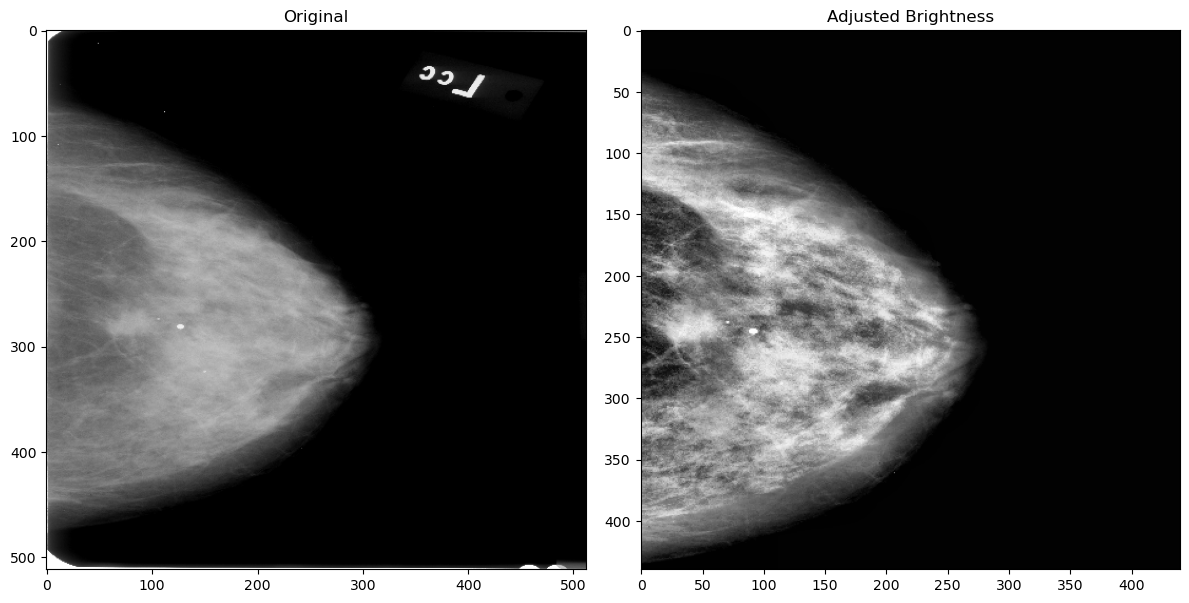

In [21]:
# from PIL import Image, ImageEnhance
# import numpy as np
# import matplotlib.pyplot as plt

 
# # Load a sample image
# image_path = 'test2.png'  # Update with your image path
# sample_image = Image.open(image_path)
 
# img_crop_size = int(sample_image.size[0] * 0.86)
# print("img_crop_size", img_crop_size)
# # Adjust its brightness
# # Define crop coordinates
# left = 100
# upper = 100
# right = 300
# lower = 300


# # Crop the image
# ccp = CenterCropPercentage(0.86)
# cropped_img = ccp(sample_image)
 
# adjusted_image = segment_and_visualize_transform(cropped_img)
# enhance_contrast_using_clahe_image = enhance_contrast_using_clahe(adjusted_image)
# # Convert images to numpy arrays for plotting
# original_np = np.array(sample_image)
# adjusted_np = np.array(enhance_contrast_using_clahe_image)

# # Plot original and adjusted images side by side for comparison
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.imshow(original_np, cmap='gray')
# plt.title('Original')
# #plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(adjusted_np, cmap='gray')
# plt.title('Adjusted Brightness')
# #plt.axis('off')

# plt.tight_layout()
# plt.show()
